# Dependencies

In [1]:
import tensorflow as tf
import numpy as np
import os
from collections import Counter
from matplotlib import pyplot as plt
import pandas as pd
#from sklearn.metrics import confusion_matrix

In [2]:
import sys
sys.path.append('/usr/local/opt/opencv/lib//python3.6/site-packages/')
import cv2

# Load Data

In [256]:
def get_rec_files(path,ext):
    content = os.listdir(path)
    if len(content) == 0:
        return []
    if ".DS_Store" in content:
        content.remove(".DS_Store")
    if content[0].endswith(ext):
        return [path+"/"+file for file in content]
    else:
        return np.concatenate([get_rec_files(path+"/"+subpath,ext) for subpath in content])

In [257]:
images = get_rec_files("data/images",".png")

In [258]:
images[:10]

array(['data/images/S111/007/S111_007_00000008.png',
       'data/images/S111/007/S111_007_00000009.png',
       'data/images/S111/007/S111_007_00000013.png',
       'data/images/S111/007/S111_007_00000007.png',
       'data/images/S111/007/S111_007_00000006.png',
       'data/images/S111/007/S111_007_00000012.png',
       'data/images/S111/007/S111_007_00000004.png',
       'data/images/S111/007/S111_007_00000010.png',
       'data/images/S111/007/S111_007_00000011.png',
       'data/images/S111/007/S111_007_00000005.png'], dtype='<U42')

In [259]:
emotions = get_rec_files("data/emotions",".txt")

In [260]:
emotions[:10]

array(['data/emotions/S111/007/S111_007_00000014_emotion.txt',
       'data/emotions/S111/001/S111_001_00000014_emotion.txt',
       'data/emotions/S111/006/S111_006_00000010_emotion.txt',
       'data/emotions/S129/012/S129_012_00000011_emotion.txt',
       'data/emotions/S129/006/S129_006_00000010_emotion.txt',
       'data/emotions/S129/011/S129_011_00000018_emotion.txt',
       'data/emotions/S129/002/S129_002_00000011_emotion.txt',
       'data/emotions/S116/007/S116_007_00000017_emotion.txt',
       'data/emotions/S116/001/S116_001_00000014_emotion.txt',
       'data/emotions/S116/006/S116_006_00000007_emotion.txt'],
      dtype='<U52')

In [261]:
def merge_groups(emotions,images):
    groups = []
    for emotion in emotions:
        emot_value = get_emot_value(emotion)
        prefix = emotion.split("/")[-1][:8]
        f=np.frompyfunc(lambda x: prefix in x, 1,1)
        selected_images = images[list(f(images))]
        selected_images.sort()
        groups += [(emot_value,selected_images)]
    return groups

In [262]:
def get_emot_value(path):
    with open(path,"r") as f:
        return f.read().split()[0][0]

In [263]:
group_images = merge_groups(emotions,images)

In [264]:
group_images[:2]

[('3', array(['data/images/S111/007/S111_007_00000001.png',
         'data/images/S111/007/S111_007_00000002.png',
         'data/images/S111/007/S111_007_00000003.png',
         'data/images/S111/007/S111_007_00000004.png',
         'data/images/S111/007/S111_007_00000005.png',
         'data/images/S111/007/S111_007_00000006.png',
         'data/images/S111/007/S111_007_00000007.png',
         'data/images/S111/007/S111_007_00000008.png',
         'data/images/S111/007/S111_007_00000009.png',
         'data/images/S111/007/S111_007_00000010.png',
         'data/images/S111/007/S111_007_00000011.png',
         'data/images/S111/007/S111_007_00000012.png',
         'data/images/S111/007/S111_007_00000013.png',
         'data/images/S111/007/S111_007_00000014.png'], dtype='<U42')),
 ('7', array(['data/images/S111/001/S111_001_00000001.png',
         'data/images/S111/001/S111_001_00000002.png',
         'data/images/S111/001/S111_001_00000003.png',
         'data/images/S111/001/S111_00

In [265]:
emot_count = [emot for emot,image in group_images]

In [266]:
Counter(emot_count)

Counter({'1': 45, '2': 18, '3': 59, '4': 25, '5': 69, '6': 28, '7': 83})

## FER2013 Dataset

In [267]:
df = pd.read_csv("data/fer2013.csv",sep=",")

In [268]:
df["intensity"] = -1

In [269]:
df.groupby("Usage").count()

,emotion,pixels,intensity
Usage,,,
PrivateTest,3589,3589,3589
PublicTest,3589,3589,3589
Training,28709,28709,28709


# Image Preparation

In [272]:
def prepare_images(images):
    faceCascade = cv2.CascadeClassifier("data/face_recog.xml")
    prepared_images = []
    
    for path in images:
        
        image = cv2.imread(path)
        
        faces = faceCascade.detectMultiScale(
            image,
            scaleFactor=1.1,
            minNeighbors=5,
            minSize=(48,48),
            flags = cv2.CASCADE_SCALE_IMAGE
        )
        for (x, y, w, h) in faces:
            crop_img = image[y:y+h, x:x+w]
            
        res_img = cv2.resize(cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY), (48,48)) 
        
        prepared_images += [(res_img,path)]
        
    return prepared_images

In [273]:
group_faces = []
for emot,pictures in group_images:
    group_faces += [(emot,prepare_images(pictures))]


In [274]:
ck_data = []
for emot,pictures in group_faces:
    for picture,path in pictures:
        ck_data += [[emot,np.concatenate(picture),int(path.split("_")[-1][:-4])]] 

In [298]:
ck_df = pd.DataFrame(data=ck_data,columns=["emotion","pixels","intensity"])
ck_df["Usage"] = "CK+"
ck_df["emotion"] = pd.to_numeric(ck_df["emotion"])
ck_df["pixels"] = [" ".join([str(string) for string in pixels]) for pixels in ck_df["pixels"].values]

In [299]:
ck_df.head()

,emotion,pixels,intensity,Usage
0,3,44 34 21 0 0 0 0 0 0 2 7 15 18 36 34 35 47 60 ...,1,CK+
1,3,42 36 3 0 0 0 0 0 0 0 5 15 22 31 32 37 52 60 8...,2,CK+
2,3,42 35 26 0 0 0 0 0 0 0 4 8 16 32 34 33 42 58 8...,3,CK+
3,3,43 34 10 1 0 0 0 0 0 2 7 13 19 36 32 36 44 62 ...,4,CK+
4,3,43 40 38 0 0 0 0 0 0 1 6 9 15 28 31 34 42 63 7...,5,CK+


## Optional: Save to File

In [55]:
paths = []
for emot,pictures in group_faces:
    for pixel,path in pictures:
        file_name = path.split("/")[-1]
        name = file_name.split(".")[0]
        
        face_path = "data/faces/"+name+"_"+emot
        np.save(face_path,pixel)
        paths += [(emot,face_path)]

# Combine Datasets

In [308]:
complete_df = pd.concat([df,ck_df])

FER2013
Emotion labels in the dataset:
- 0: -4593 images- Angry
- 1: -547 images- Disgust
- 2: -5121 images- Fear
- 3: -8989 images- Happy
- 4: -6077 images- Sad
- 5: -4002 images- Surprise
- 6: -6198 images- Neutral

CK+
- {0=neutral, 1=anger, 2=contempt, 3=disgust, 4=fear, 5=happy, 6=sadness, 7=surprise}

In [97]:
#go with the FER2013 emotion standard
emotion_map = {
    0:6,
    1:0,
    3:1,
    4:2,
    5:3,
    6:4,
    7:5
}

emotion_string = {
    0:"Angry",
    1:"Disgust",
    2:"Fear",
    3:"Happy",
    4:"Sad",
    5:"Surprise",
    6:"Neutral",
}

delete_label = 2

In [309]:
def map_emotions(row):
    if row["Usage"] == "CK+":
        row["emotion"] = emotion_map[row["emotion"]]
    return row

In [310]:
complete_df = complete_df.drop(complete_df.loc[(complete_df["emotion"] == delete_label) & (complete_df["intensity"] != -1)].index)

In [311]:
complete_df = complete_df.apply(lambda x: map_emotions(x),axis=1)

In [312]:
complete_df.to_csv("data/face_dataset.csv",sep="|",index=False)

# Model Definition

In [2]:
def string_to_float_list(row):
    row["pixels"] = np.array([float(string) for string in row["pixels"].split()])

    return row

In [3]:
dataset = pd.read_csv("~/data/emotion_reco/face_dataset.csv",sep="|")
dataset = dataset.apply(lambda x: string_to_float_list(x),axis=1)

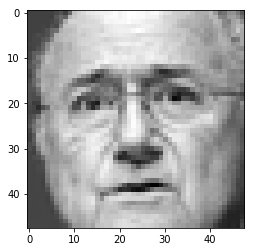

In [6]:
plt.imshow(np.reshape([int(x) for x in dataset["pixels"][5]],(48,48)), cmap="gray")

# ONLY FRE2013 DATASET

In [4]:
df = pd.read_csv("data/fer2013/fer2013.csv",sep=",")

In [5]:
df = df.apply(lambda x: string_to_float_list(x), axis=1)

In [6]:
df.head(5)

,emotion,pixels,Usage
0,0,"[70.0, 80.0, 82.0, 72.0, 58.0, 58.0, 60.0, 63....",Training
1,0,"[151.0, 150.0, 147.0, 155.0, 148.0, 133.0, 111...",Training
2,2,"[231.0, 212.0, 156.0, 164.0, 174.0, 138.0, 161...",Training
3,4,"[24.0, 32.0, 36.0, 30.0, 32.0, 23.0, 19.0, 20....",Training
4,6,"[4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Training


In [4]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""
    # Convert the inputs to a Dataset.

    #tf_split = tf.string_split(features,delimiter=' ').values
    #features_split = tf.cast(tf.reshape(tf_split,[48*48]),dtype=tf.float32)
    #features_split = tf.cast(features,dtype=tf.float32)

    
    dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    # Shuffle, repeat, and batch the examples.
    dataset = dataset.shuffle(1000).repeat().batch(batch_size)

    # Return the dataset.
    return dataset

In [5]:
def eval_input_fn(features, labels=None, batch_size=None):
    """An input function for evaluation or prediction"""
    
    if labels is None:
        # No labels, use only features.
        inputs = features
    else:
        inputs = (features, labels)
    
    # Convert inputs to a tf.dataset object.
    dataset = tf.data.Dataset.from_tensor_slices(inputs)

    # Batch the examples
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    # Return the read end of the pipeline.
    return dataset.make_one_shot_iterator().get_next()

![title](emotion_cnn1.png)

In [6]:
def create_conv_layer(inputs,filters,kernels,padding,strides,pools,name,mode):
    #print(inputs,filters,kernels,padding,strides,pools,name,mode)
    conv_layer = tf.contrib.layers.conv2d(
        inputs=inputs,
        num_outputs=filters,
        kernel_size=kernels,
        padding=padding,
        stride=1,
        activation_fn=tf.nn.relu,
        normalizer_fn=tf.contrib.layers.batch_norm
    )
    
    #batch_norm = tf.contrib.layers.batch_norm(
    #    inputs=conv_layer)
    
    relu_act = tf.nn.relu(
        features=conv_layer)
    
    dropout = tf.layers.dropout(
        inputs=relu_act,
        #rate=0.4,
        training = mode == tf.estimator.ModeKeys.TRAIN)
    
    pooling = tf.layers.max_pooling2d(
        inputs=dropout,
        pool_size=pools,
        strides=strides,
        padding=padding)
    
    return pooling
    

In [7]:
def create_fc_layer(inputs,neurons,mode):
    fc_layer = tf.layers.dense(
        inputs=inputs,
        units=neurons
    )
    
    batch_norm = tf.layers.batch_normalization(inputs=fc_layer)
    
    dropout = tf.layers.dropout(
        inputs=batch_norm,
        #rate=0.4,
        training=mode == tf.estimator.ModeKeys.TRAIN)
    
    relu_act = tf.nn.relu(
        features=dropout)

    return relu_act
    

In [8]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""
    n_conv = [(2,3,64),(2,5,128),(2,3,512)]
    n_fc = [256,512]
    
    # Input Layer
    input_layer = tf.reshape(tf.cast(features,tf.float32), [-1, 48, 48, 1])
    print(labels)
    #one_hot_labels = tf.one_hot(labels,7)
    
    conv_layer = input_layer
    
    for s,k,f in n_conv:
        conv_layer = create_conv_layer(
            inputs=conv_layer,
            filters=f,
            kernels=[k,k],
            padding="same",
            strides=s,
            pools=[2,2],
            name="conv"+str(f),
            mode=mode
            )
        
    
    
    fc_layer = tf.reshape(conv_layer,[-1,6*6*512])
    
    for n in n_fc:
        fc_layer = create_fc_layer(
            inputs=fc_layer,
            neurons=n,
            mode=mode
        )
        print(fc_layer)
        
    logits = tf.layers.dense(inputs=fc_layer, units=7)
    
    softmax = tf.nn.softmax(logits, name="softmax_tensor")

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": softmax
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [67]:
def dense_block(inputs, size, filters, kernel, padding="same", activation=tf.nn.relu, name="denseblock"):
    
    with tf.variable_scope(name) as scope:
        inp = inputs

        for i in range(1, size+1):

            dense_layer = tf.layers.batch_normalization(inputs=inp)
            dense_layer = tf.nn.relu(dense_layer)
            
            dense_layer = tf.layers.conv2d(inputs=dense_layer,
                                          filters=4*filters,
                                          kernel_size=[1,1],
                                          activation=activation,
                                          #use_bias=False,
                                          padding=padding,
                                          name="bottleneck-layer-"+str(i)
                                          )
            
            dense_layer = tf.layers.batch_normalization(inputs=inp)
            dense_layer = tf.nn.relu(dense_layer)
            
            dense_layer = tf.layers.conv2d(inputs=dense_layer,
                                          filters=filters,
                                          kernel_size=kernel,
                                          activation=activation,
                                          #use_bias=False,
                                          padding=padding,
                                          name="conv-layer-"+str(i)
                                          )

            inp = tf.concat([inp, dense_layer], 3)
        
    return inp

In [76]:
def dense_transition(inputs, filters, activation=tf.nn.relu, name="transition-layer"):
    
    with tf.variable_scope(name) as scope:
        transition = tf.layers.batch_normalization(inputs=inputs)
        transition = tf.nn.relu(transition)
        
        transition = tf.layers.conv2d(inputs=transition,
                                          filters=filters,
                                          kernel_size=[1 ,1],
                                          activation=activation,
                                          #use_bias=False,
                                          padding="same",
                                          name="bottleneck-"
                                          )
        
        transition = tf.layers.average_pooling2d(inputs=transition, pool_size=[2,2], strides=2)
        
    return transition

In [86]:
def cnn_dense_model_fn(features, labels, mode):
    """Model function for CNN."""
    filters = 6
    kernel = [3, 3]
    compression_factor = 0.5
    
    n_fc = [500]
    
    dense_sizes = [6]
    dense_blocks = len(dense_sizes)
    
    # Input Layer
    input_layer = tf.reshape(tf.cast(features,tf.float32), [-1, 48, 48, 1])
    #one_hot_labels = tf.one_hot(labels,7)
    
    in_layer = create_conv_layer(inputs=input_layer,
                                  filters=filters,
                                  kernels=kernel,
                                  padding="same",
                                  strides=2,
                                  pools=[2,2],
                                  name="conv-1",
                                  mode=mode)    
    
    
    for i, size in zip(range(1, dense_blocks+1), dense_sizes):
        denseblock = dense_block(inputs=in_layer, 
                                  size=size, 
                                  filters=filters, 
                                  kernel=kernel, 
                                  name="denseblock-"+str(i))

        if i != dense_blocks:
            in_layer = dense_transition(inputs=denseblock, 
                                       filters=int(int(denseblock.shape[3])*compression_factor), 
                                       name="transition-layer-"+str(i))

        else:
            # final "transition" layer
            last_layer_dense = tf.layers.average_pooling2d(inputs=denseblock, pool_size=[2,2], strides=2)
        
        
    dense_units_output = last_layer_dense.shape[1] * last_layer_dense.shape[2] * last_layer_dense.shape[3]
        
    
    fc_layer = tf.reshape(last_layer_dense, [-1, dense_units_output])
    
    for n in n_fc:
        fc_layer = create_fc_layer(
            inputs=fc_layer,
            neurons=n,
            mode=mode
        )
        
        
    logits = tf.layers.dense(inputs=fc_layer, units=7)
    
    softmax = tf.nn.softmax(logits, name="softmax_tensor")

    predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": softmax
    }

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)
    

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

# Model Training

In [73]:
emotion_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="tmp/mnist_convnet_model")


tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=2000)

tf.logging.set_verbosity(tf.logging.INFO)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_session_config': None, '_keep_checkpoint_max': 5, '_save_checkpoints_secs': 600, '_train_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_evaluation_master': '', '_is_chief': True, '_save_checkpoints_steps': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1fbc0284e0>, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_task_type': 'worker', '_model_dir': 'tmp/mnist_convnet_model', '_global_id_in_cluster': 0, '_master': '', '_log_step_count_steps': 100}


In [12]:
def df_to_tensor(series):
    return np.concatenate(series.values).reshape(len(series),len(series[0]))

In [13]:
x = df_to_tensor(dataset["pixels"])
y = dataset["emotion"].values

In [74]:
emotion_classifier.train(
    input_fn=lambda:train_input_fn(
        x,
        y,
        128),
    steps=2*40000,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
Tensor("IteratorGetNext:1", shape=(?,), dtype=int64)
Tensor("Relu_3:0", shape=(?, 256), dtype=float32)
Tensor("Relu_4:0", shape=(?, 512), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into tmp/mnist_convnet_model/model.ckpt.
INFO:tensorflow:probabilities = [[0.02553924 0.00089641 0.00319786 0.00104917 0.01578803 0.0001424
  0.9533869 ]
 [0.00001508 0.00002906 0.05658188 0.00536306 0.93758494 0.00001636
  0.00040968]
 [0.25130326 0.00016103 0.0007483  0.56951696 0.03759281 0.13900405
  0.00167356]
 [0.00009294 0.000007   0.00036156 0.00004091 0.99848443 0.0007575
  0.00025567]
 [0.00004862 0.01146108 0.0322392  0.00054708 0.43275648 0.32021722
  0.20273024]
 [0.00026096 0.00000124 0.00664283 0.00029948 0.09919111 0.00658135
  0.88702303]
 [0.00

INFO:tensorflow:loss = 4.271625, step = 0
INFO:tensorflow:global_step/sec: 23.3674
INFO:tensorflow:loss = 1.8631831, step = 100 (4.258 sec)
INFO:tensorflow:global_step/sec: 27.0291
INFO:tensorflow:loss = 1.7862787, step = 200 (3.700 sec)
INFO:tensorflow:global_step/sec: 26.8095
INFO:tensorflow:loss = 1.870524, step = 300 (3.729 sec)
INFO:tensorflow:global_step/sec: 26.9026
INFO:tensorflow:loss = 1.801594, step = 400 (3.717 sec)
INFO:tensorflow:global_step/sec: 26.7623
INFO:tensorflow:loss = 1.7820593, step = 500 (3.737 sec)
INFO:tensorflow:global_step/sec: 26.986
INFO:tensorflow:loss = 2.0362828, step = 600 (3.706 sec)
INFO:tensorflow:global_step/sec: 27.3382
INFO:tensorflow:loss = 1.8528643, step = 700 (3.657 sec)
INFO:tensorflow:global_step/sec: 27.7137
INFO:tensorflow:loss = 1.7993321, step = 800 (3.608 sec)
INFO:tensorflow:global_step/sec: 27.7147
INFO:tensorflow:loss = 1.7796795, step = 900 (3.608 sec)
INFO:tensorflow:global_step/sec: 27.6923
INFO:tensorflow:loss = 1.8827271, step

INFO:tensorflow:loss = 1.8586736, step = 2000 (3.688 sec)
INFO:tensorflow:global_step/sec: 26.8931
INFO:tensorflow:loss = 1.7657622, step = 2100 (3.706 sec)
INFO:tensorflow:global_step/sec: 26.9952
INFO:tensorflow:loss = 1.7820454, step = 2200 (3.705 sec)
INFO:tensorflow:global_step/sec: 27.4137
INFO:tensorflow:loss = 1.7625759, step = 2300 (3.646 sec)
INFO:tensorflow:global_step/sec: 27.72
INFO:tensorflow:loss = 1.8069658, step = 2400 (3.608 sec)
INFO:tensorflow:global_step/sec: 27.7975
INFO:tensorflow:loss = 1.8358965, step = 2500 (3.598 sec)
INFO:tensorflow:global_step/sec: 27.804
INFO:tensorflow:loss = 1.7918944, step = 2600 (3.595 sec)
INFO:tensorflow:global_step/sec: 27.6757
INFO:tensorflow:loss = 1.828929, step = 2700 (3.613 sec)
INFO:tensorflow:global_step/sec: 27.7734
INFO:tensorflow:loss = 1.8327086, step = 2800 (3.601 sec)
INFO:tensorflow:global_step/sec: 27.7878
INFO:tensorflow:loss = 1.9565755, step = 2900 (3.599 sec)
INFO:tensorflow:global_step/sec: 27.4207
INFO:tensorflo

INFO:tensorflow:loss = 1.8361695, step = 4000 (3.639 sec)
INFO:tensorflow:global_step/sec: 27.5746
INFO:tensorflow:loss = 1.7877985, step = 4100 (3.605 sec)
INFO:tensorflow:global_step/sec: 27.6351
INFO:tensorflow:loss = 1.8818773, step = 4200 (3.618 sec)
INFO:tensorflow:global_step/sec: 27.0564
INFO:tensorflow:loss = 1.8059155, step = 4300 (3.696 sec)
INFO:tensorflow:global_step/sec: 26.8862
INFO:tensorflow:loss = 1.8228246, step = 4400 (3.719 sec)
INFO:tensorflow:global_step/sec: 26.8564
INFO:tensorflow:loss = 2.0808868, step = 4500 (3.724 sec)
INFO:tensorflow:global_step/sec: 27.5567
INFO:tensorflow:loss = 1.8260492, step = 4600 (3.629 sec)
INFO:tensorflow:global_step/sec: 27.898
INFO:tensorflow:loss = 1.788718, step = 4700 (3.583 sec)
INFO:tensorflow:global_step/sec: 27.7227
INFO:tensorflow:loss = 2.107677, step = 4800 (3.607 sec)
INFO:tensorflow:global_step/sec: 27.6745
INFO:tensorflow:loss = 1.8468777, step = 4900 (3.614 sec)


KeyboardInterrupt: 

In [496]:

np.concatenate(dataset["pixels"].values).reshape(len(dataset["pixels"]),len(dataset["pixels"][0])).shape

(41297, 2304)

In [87]:
emotion_classifier_dense = tf.estimator.Estimator(
    model_fn=cnn_dense_model_fn, model_dir="tmp/convnet_dense_model-2")


tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(
  tensors=tensors_to_log, every_n_iter=2000)

tf.logging.set_verbosity(tf.logging.INFO)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_tf_random_seed': None, '_session_config': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f1ce537f390>, '_evaluation_master': '', '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_model_dir': 'tmp/convnet_dense_model-2', '_is_chief': True, '_master': '', '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_service': None, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_global_id_in_cluster': 0, '_task_type': 'worker', '_train_distribute': None, '_save_checkpoints_secs': 600, '_save_summary_steps': 100}


In [16]:
x = df_to_tensor(df["pixels"])
y = df["emotion"].values

In [94]:
emotion_classifier_dense.train(
    input_fn=lambda:train_input_fn(
        x,
        y,
        128),
    steps=10*35000,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/convnet_dense_model-2/model.ckpt-53228
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 53229 into tmp/convnet_dense_model-2/model.ckpt.
INFO:tensorflow:probabilities = [[0.7506229  0.00002389 0.15768747 0.01441993 0.07515392 0.00062313
  0.00146879]
 [0.00000086 0.         0.         0.99999917 0.         0.
  0.00000001]
 [0.00000043 0.         0.99737954 0.00023906 0.00000547 0.00237544
  0.        ]
 [0.013995   0.00000042 0.00006444 0.98577195 0.000027   0.00012281
  0.00001837]
 [0.00107841 0.00000006 0.00070212 0.9852691  0.00109657 0.00149696
  0.01035676]
 [0.00553681 0.00226117 0.00023439 0.9783668  0.00003147 0.00001214
  0.01355718]
 [0.00334904 0.00000095 0.3206688  0.00006114 0.6437559  0.0000182
  0.032

INFO:tensorflow:step = 53228, loss = 0.4809245
INFO:tensorflow:global_step/sec: 10.5517
INFO:tensorflow:step = 53328, loss = 0.4614358 (9.461 sec)
INFO:tensorflow:global_step/sec: 14.83
INFO:tensorflow:step = 53428, loss = 0.6744636 (6.742 sec)
INFO:tensorflow:global_step/sec: 14.8856
INFO:tensorflow:step = 53528, loss = 0.34017026 (6.719 sec)
INFO:tensorflow:global_step/sec: 14.9892
INFO:tensorflow:step = 53628, loss = 0.60013574 (6.671 sec)
INFO:tensorflow:global_step/sec: 14.8924
INFO:tensorflow:step = 53728, loss = 0.6737512 (6.715 sec)
INFO:tensorflow:global_step/sec: 15.0661
INFO:tensorflow:step = 53828, loss = 0.4290589 (6.637 sec)
INFO:tensorflow:global_step/sec: 14.7874
INFO:tensorflow:step = 53928, loss = 0.5770837 (6.763 sec)
INFO:tensorflow:global_step/sec: 14.7675
INFO:tensorflow:step = 54028, loss = 0.43928924 (6.773 sec)
INFO:tensorflow:global_step/sec: 14.7794
INFO:tensorflow:step = 54128, loss = 0.5152421 (6.765 sec)
INFO:tensorflow:global_step/sec: 15.1451
INFO:tensor

INFO:tensorflow:step = 55228, loss = 0.53366315 (6.770 sec)
INFO:tensorflow:global_step/sec: 14.7225
INFO:tensorflow:step = 55328, loss = 0.55697334 (6.769 sec)
INFO:tensorflow:global_step/sec: 14.7486
INFO:tensorflow:step = 55428, loss = 0.499915 (6.781 sec)
INFO:tensorflow:global_step/sec: 14.9608
INFO:tensorflow:step = 55528, loss = 0.4880091 (6.684 sec)
INFO:tensorflow:global_step/sec: 15.004
INFO:tensorflow:step = 55628, loss = 0.5378803 (6.664 sec)
INFO:tensorflow:global_step/sec: 15.0602
INFO:tensorflow:step = 55728, loss = 0.47679642 (6.640 sec)
INFO:tensorflow:global_step/sec: 14.9232
INFO:tensorflow:step = 55828, loss = 0.4112153 (6.701 sec)
INFO:tensorflow:global_step/sec: 14.8324
INFO:tensorflow:step = 55928, loss = 0.53087044 (6.742 sec)
INFO:tensorflow:global_step/sec: 14.857
INFO:tensorflow:step = 56028, loss = 0.56415445 (6.731 sec)
INFO:tensorflow:global_step/sec: 14.7846
INFO:tensorflow:step = 56128, loss = 0.16077662 (6.765 sec)
INFO:tensorflow:global_step/sec: 14.96

INFO:tensorflow:step = 57228, loss = 0.63723755 (6.708 sec)
INFO:tensorflow:global_step/sec: 14.9793
INFO:tensorflow:step = 57328, loss = 0.5621346 (6.653 sec)
INFO:tensorflow:global_step/sec: 15.1078
INFO:tensorflow:step = 57428, loss = 0.6096824 (6.619 sec)
INFO:tensorflow:global_step/sec: 14.743
INFO:tensorflow:step = 57528, loss = 0.38023993 (6.783 sec)
INFO:tensorflow:global_step/sec: 14.7487
INFO:tensorflow:step = 57628, loss = 0.57033485 (6.780 sec)
INFO:tensorflow:global_step/sec: 14.8224
INFO:tensorflow:step = 57728, loss = 0.18942732 (6.746 sec)
INFO:tensorflow:global_step/sec: 15.0349
INFO:tensorflow:step = 57828, loss = 0.60286415 (6.651 sec)
INFO:tensorflow:global_step/sec: 14.953
INFO:tensorflow:step = 57928, loss = 0.4823571 (6.689 sec)
INFO:tensorflow:global_step/sec: 14.9546
INFO:tensorflow:step = 58028, loss = 0.24169864 (6.685 sec)
INFO:tensorflow:global_step/sec: 15.1063
INFO:tensorflow:step = 58128, loss = 0.58189 (6.624 sec)
INFO:tensorflow:global_step/sec: 15.069

INFO:tensorflow:step = 59228, loss = 0.5924046 (6.697 sec)
INFO:tensorflow:global_step/sec: 14.9079
INFO:tensorflow:step = 59328, loss = 0.22897555 (6.685 sec)
INFO:tensorflow:global_step/sec: 14.7883
INFO:tensorflow:step = 59428, loss = 0.6078841 (6.763 sec)
INFO:tensorflow:global_step/sec: 14.8408
INFO:tensorflow:step = 59528, loss = 0.4308159 (6.738 sec)
INFO:tensorflow:global_step/sec: 14.8616
INFO:tensorflow:step = 59628, loss = 0.5101879 (6.729 sec)
INFO:tensorflow:global_step/sec: 15.027
INFO:tensorflow:step = 59728, loss = 0.6669303 (6.656 sec)
INFO:tensorflow:global_step/sec: 15.0515
INFO:tensorflow:step = 59828, loss = 0.5169306 (6.643 sec)
INFO:tensorflow:global_step/sec: 14.9644
INFO:tensorflow:step = 59928, loss = 0.5272587 (6.682 sec)
INFO:tensorflow:global_step/sec: 15.0208
INFO:tensorflow:step = 60028, loss = 0.5726832 (6.657 sec)
INFO:tensorflow:global_step/sec: 15.0903
INFO:tensorflow:step = 60128, loss = 0.68706214 (6.627 sec)
INFO:tensorflow:global_step/sec: 14.8743

INFO:tensorflow:step = 61228, loss = 0.5418903 (6.769 sec)
INFO:tensorflow:global_step/sec: 14.767
INFO:tensorflow:step = 61328, loss = 0.54975796 (6.747 sec)
INFO:tensorflow:global_step/sec: 15.0974
INFO:tensorflow:step = 61428, loss = 0.6083853 (6.623 sec)
INFO:tensorflow:global_step/sec: 14.9641
INFO:tensorflow:step = 61528, loss = 0.4849654 (6.683 sec)
INFO:tensorflow:global_step/sec: 15.1683
INFO:tensorflow:step = 61628, loss = 0.566246 (6.592 sec)
INFO:tensorflow:global_step/sec: 14.9583
INFO:tensorflow:step = 61728, loss = 0.40534163 (6.685 sec)
INFO:tensorflow:global_step/sec: 14.9843
INFO:tensorflow:step = 61828, loss = 0.6651338 (6.674 sec)
INFO:tensorflow:global_step/sec: 15.0251
INFO:tensorflow:step = 61928, loss = 0.16068898 (6.656 sec)
INFO:tensorflow:global_step/sec: 14.9237
INFO:tensorflow:step = 62028, loss = 0.4427634 (6.701 sec)
INFO:tensorflow:Saving checkpoints for 62038 into tmp/convnet_dense_model-2/model.ckpt.
INFO:tensorflow:global_step/sec: 6.99878
INFO:tensor

INFO:tensorflow:step = 63228, loss = 0.1118035 (6.820 sec)
INFO:tensorflow:global_step/sec: 15.0122
INFO:tensorflow:step = 63328, loss = 0.52203476 (6.642 sec)
INFO:tensorflow:global_step/sec: 15.0004
INFO:tensorflow:step = 63428, loss = 0.56536555 (6.665 sec)
INFO:tensorflow:global_step/sec: 14.9961
INFO:tensorflow:step = 63528, loss = 0.439229 (6.668 sec)
INFO:tensorflow:global_step/sec: 14.9669
INFO:tensorflow:step = 63628, loss = 0.522775 (6.681 sec)
INFO:tensorflow:global_step/sec: 15.1387
INFO:tensorflow:step = 63728, loss = 0.39549577 (6.607 sec)
INFO:tensorflow:global_step/sec: 14.9986
INFO:tensorflow:step = 63828, loss = 0.34049514 (6.666 sec)
INFO:tensorflow:global_step/sec: 14.734
INFO:tensorflow:step = 63928, loss = 0.5699294 (6.786 sec)
INFO:tensorflow:global_step/sec: 14.794
INFO:tensorflow:step = 64028, loss = 0.39109302 (6.759 sec)
INFO:tensorflow:global_step/sec: 14.8818
INFO:tensorflow:step = 64128, loss = 0.5398392 (6.720 sec)
INFO:tensorflow:global_step/sec: 14.9075

INFO:tensorflow:step = 65228, loss = 0.49889365 (6.722 sec)
INFO:tensorflow:global_step/sec: 14.8892
INFO:tensorflow:step = 65328, loss = 0.5059225 (6.696 sec)
INFO:tensorflow:global_step/sec: 15.0551
INFO:tensorflow:step = 65428, loss = 0.43640345 (6.641 sec)
INFO:tensorflow:global_step/sec: 15.0459
INFO:tensorflow:step = 65528, loss = 0.5046621 (6.648 sec)
INFO:tensorflow:global_step/sec: 15.0109
INFO:tensorflow:step = 65628, loss = 0.41000885 (6.660 sec)
INFO:tensorflow:global_step/sec: 15.0071
INFO:tensorflow:step = 65728, loss = 0.56434387 (6.663 sec)
INFO:tensorflow:global_step/sec: 14.9485
INFO:tensorflow:step = 65828, loss = 0.45759967 (6.689 sec)
INFO:tensorflow:global_step/sec: 14.6946
INFO:tensorflow:step = 65928, loss = 0.5563908 (6.805 sec)
INFO:tensorflow:global_step/sec: 14.864
INFO:tensorflow:step = 66028, loss = 0.37023416 (6.727 sec)
INFO:tensorflow:global_step/sec: 14.8725
INFO:tensorflow:step = 66128, loss = 0.16075552 (6.724 sec)
INFO:tensorflow:global_step/sec: 15

INFO:tensorflow:step = 67228, loss = 0.5198805 (6.672 sec)
INFO:tensorflow:global_step/sec: 14.9768
INFO:tensorflow:step = 67328, loss = 0.4076211 (6.654 sec)
INFO:tensorflow:global_step/sec: 15.088
INFO:tensorflow:step = 67428, loss = 0.5980521 (6.626 sec)
INFO:tensorflow:global_step/sec: 15.0153
INFO:tensorflow:step = 67528, loss = 0.5514741 (6.660 sec)
INFO:tensorflow:global_step/sec: 15.0638
INFO:tensorflow:step = 67628, loss = 0.4493448 (6.638 sec)
INFO:tensorflow:global_step/sec: 14.9435
INFO:tensorflow:step = 67728, loss = 0.15430205 (6.692 sec)
INFO:tensorflow:global_step/sec: 14.8275
INFO:tensorflow:step = 67828, loss = 0.61611676 (6.744 sec)
INFO:tensorflow:global_step/sec: 14.7736
INFO:tensorflow:step = 67928, loss = 0.5311646 (6.769 sec)
INFO:tensorflow:global_step/sec: 14.7818
INFO:tensorflow:step = 68028, loss = 0.15572305 (6.765 sec)
INFO:tensorflow:global_step/sec: 14.8838
INFO:tensorflow:step = 68128, loss = 0.49123788 (6.719 sec)
INFO:tensorflow:global_step/sec: 15.08

INFO:tensorflow:step = 69228, loss = 0.57762384 (6.695 sec)
INFO:tensorflow:global_step/sec: 14.9797
INFO:tensorflow:step = 69328, loss = 0.13216746 (6.655 sec)
INFO:tensorflow:global_step/sec: 15.048
INFO:tensorflow:step = 69428, loss = 0.4581901 (6.646 sec)
INFO:tensorflow:global_step/sec: 15.1101
INFO:tensorflow:step = 69528, loss = 0.56648844 (6.617 sec)
INFO:tensorflow:global_step/sec: 15.0121
INFO:tensorflow:step = 69628, loss = 0.61692214 (6.662 sec)
INFO:tensorflow:global_step/sec: 14.8093
INFO:tensorflow:step = 69728, loss = 0.4202361 (6.754 sec)
INFO:tensorflow:global_step/sec: 14.7827
INFO:tensorflow:step = 69828, loss = 0.56601447 (6.763 sec)
INFO:tensorflow:global_step/sec: 14.9246
INFO:tensorflow:step = 69928, loss = 0.5177015 (6.701 sec)
INFO:tensorflow:global_step/sec: 14.8046
INFO:tensorflow:step = 70028, loss = 0.54713166 (6.755 sec)
INFO:tensorflow:global_step/sec: 15.0251
INFO:tensorflow:step = 70128, loss = 0.47851735 (6.657 sec)
INFO:tensorflow:global_step/sec: 14

INFO:tensorflow:step = 71228, loss = 0.40322983 (6.688 sec)
INFO:tensorflow:global_step/sec: 14.9937
INFO:tensorflow:step = 71328, loss = 0.4591423 (6.648 sec)
INFO:tensorflow:global_step/sec: 15.0384
INFO:tensorflow:step = 71428, loss = 0.5104853 (6.650 sec)
INFO:tensorflow:global_step/sec: 14.9777
INFO:tensorflow:step = 71528, loss = 0.4487625 (6.676 sec)
INFO:tensorflow:global_step/sec: 15.1142
INFO:tensorflow:step = 71628, loss = 0.49642742 (6.616 sec)
INFO:tensorflow:global_step/sec: 14.7675
INFO:tensorflow:step = 71728, loss = 0.39848405 (6.772 sec)
INFO:tensorflow:global_step/sec: 14.8146
INFO:tensorflow:step = 71828, loss = 0.41918284 (6.751 sec)
INFO:tensorflow:global_step/sec: 14.819
INFO:tensorflow:step = 71928, loss = 0.3141296 (6.751 sec)
INFO:tensorflow:global_step/sec: 14.9288
INFO:tensorflow:step = 72028, loss = 0.722838 (6.695 sec)
INFO:tensorflow:global_step/sec: 15.0603
INFO:tensorflow:step = 72128, loss = 0.4325306 (6.641 sec)
INFO:tensorflow:global_step/sec: 14.825

INFO:tensorflow:step = 73228, loss = 0.27519777 (6.658 sec)
INFO:tensorflow:global_step/sec: 14.7984
INFO:tensorflow:step = 73328, loss = 0.40198728 (6.733 sec)
INFO:tensorflow:global_step/sec: 14.8882
INFO:tensorflow:step = 73428, loss = 0.40013027 (6.716 sec)
INFO:tensorflow:global_step/sec: 15.0578
INFO:tensorflow:step = 73528, loss = 0.20843098 (6.642 sec)
INFO:tensorflow:global_step/sec: 14.7615
INFO:tensorflow:step = 73628, loss = 0.4745285 (6.774 sec)
INFO:tensorflow:global_step/sec: 14.6826
INFO:tensorflow:step = 73728, loss = 0.4339425 (6.812 sec)
INFO:tensorflow:global_step/sec: 14.6677
INFO:tensorflow:step = 73828, loss = 0.3528462 (6.816 sec)
INFO:tensorflow:global_step/sec: 15.0255
INFO:tensorflow:step = 73928, loss = 0.509594 (6.656 sec)
INFO:tensorflow:global_step/sec: 15.0118
INFO:tensorflow:step = 74028, loss = 0.5034795 (6.662 sec)
INFO:tensorflow:global_step/sec: 15.0286
INFO:tensorflow:step = 74128, loss = 0.44224393 (6.654 sec)
INFO:tensorflow:global_step/sec: 14.9

INFO:tensorflow:step = 75228, loss = 0.39750987 (6.732 sec)
INFO:tensorflow:global_step/sec: 14.8052
INFO:tensorflow:step = 75328, loss = 0.42768133 (6.731 sec)
INFO:tensorflow:global_step/sec: 14.8988
INFO:tensorflow:step = 75428, loss = 0.54269534 (6.712 sec)
INFO:tensorflow:global_step/sec: 14.7354
INFO:tensorflow:step = 75528, loss = 0.46464798 (6.786 sec)
INFO:tensorflow:global_step/sec: 14.7489
INFO:tensorflow:step = 75628, loss = 0.4264347 (6.781 sec)
INFO:tensorflow:global_step/sec: 15.1089
INFO:tensorflow:step = 75728, loss = 0.41201094 (6.620 sec)
INFO:tensorflow:global_step/sec: 15.0771
INFO:tensorflow:step = 75828, loss = 0.45831048 (6.632 sec)
INFO:tensorflow:global_step/sec: 15.0528
INFO:tensorflow:step = 75928, loss = 0.3847872 (6.643 sec)
INFO:tensorflow:global_step/sec: 14.9137
INFO:tensorflow:step = 76028, loss = 0.5167681 (6.705 sec)
INFO:tensorflow:global_step/sec: 15.0683
INFO:tensorflow:step = 76128, loss = 0.17804733 (6.637 sec)
INFO:tensorflow:global_step/sec: 1

INFO:tensorflow:step = 77228, loss = 0.550034 (6.747 sec)
INFO:tensorflow:global_step/sec: 14.7495
INFO:tensorflow:step = 77328, loss = 0.47695076 (6.759 sec)
INFO:tensorflow:global_step/sec: 14.7598
INFO:tensorflow:step = 77428, loss = 0.47215426 (6.776 sec)
INFO:tensorflow:global_step/sec: 14.9848
INFO:tensorflow:step = 77528, loss = 0.40892148 (6.674 sec)
INFO:tensorflow:global_step/sec: 15.0398
INFO:tensorflow:step = 77628, loss = 0.3673569 (6.648 sec)
INFO:tensorflow:global_step/sec: 15.1226
INFO:tensorflow:step = 77728, loss = 0.25815853 (6.613 sec)
INFO:tensorflow:global_step/sec: 14.9046
INFO:tensorflow:step = 77828, loss = 0.5165236 (6.709 sec)
INFO:tensorflow:global_step/sec: 15.0802
INFO:tensorflow:step = 77928, loss = 0.3521364 (6.631 sec)
INFO:tensorflow:global_step/sec: 15.0023
INFO:tensorflow:step = 78028, loss = 0.25474635 (6.665 sec)
INFO:tensorflow:global_step/sec: 14.7913
INFO:tensorflow:step = 78128, loss = 0.43580988 (6.762 sec)
INFO:tensorflow:global_step/sec: 14.

INFO:tensorflow:step = 79228, loss = 0.33499384 (6.769 sec)
INFO:tensorflow:global_step/sec: 14.6151
INFO:tensorflow:step = 79328, loss = 0.2481036 (6.820 sec)
INFO:tensorflow:global_step/sec: 15.105
INFO:tensorflow:step = 79428, loss = 0.44124055 (6.623 sec)
INFO:tensorflow:global_step/sec: 14.9656
INFO:tensorflow:step = 79528, loss = 0.44795582 (6.680 sec)
INFO:tensorflow:global_step/sec: 14.9316
INFO:tensorflow:step = 79628, loss = 0.42263204 (6.696 sec)
INFO:tensorflow:global_step/sec: 15.054
INFO:tensorflow:step = 79728, loss = 0.44296157 (6.643 sec)
INFO:tensorflow:Saving checkpoints for 79737 into tmp/convnet_dense_model-2/model.ckpt.
INFO:tensorflow:global_step/sec: 7.10156
INFO:tensorflow:step = 79828, loss = 0.43847674 (14.082 sec)
INFO:tensorflow:global_step/sec: 14.8154
INFO:tensorflow:step = 79928, loss = 0.35200626 (6.750 sec)
INFO:tensorflow:global_step/sec: 14.6396
INFO:tensorflow:step = 80028, loss = 0.53233236 (6.829 sec)
INFO:tensorflow:global_step/sec: 14.9499
INFO:

INFO:tensorflow:step = 81228, loss = 0.38774914 (6.653 sec)
INFO:tensorflow:global_step/sec: 14.9174
INFO:tensorflow:step = 81328, loss = 0.57143676 (6.680 sec)
INFO:tensorflow:global_step/sec: 14.9848
INFO:tensorflow:step = 81428, loss = 0.48251757 (6.673 sec)
INFO:tensorflow:global_step/sec: 15.0844
INFO:tensorflow:step = 81528, loss = 0.3803659 (6.629 sec)
INFO:tensorflow:global_step/sec: 14.9499
INFO:tensorflow:step = 81628, loss = 0.46566448 (6.690 sec)
INFO:tensorflow:global_step/sec: 14.7158
INFO:tensorflow:step = 81728, loss = 0.33569953 (6.795 sec)
INFO:tensorflow:global_step/sec: 14.5905
INFO:tensorflow:step = 81828, loss = 0.34329867 (6.853 sec)
INFO:tensorflow:global_step/sec: 14.7371
INFO:tensorflow:step = 81928, loss = 0.099476814 (6.785 sec)
INFO:tensorflow:global_step/sec: 14.9155
INFO:tensorflow:step = 82028, loss = 0.35253596 (6.705 sec)
INFO:tensorflow:global_step/sec: 14.9749
INFO:tensorflow:step = 82128, loss = 0.38451016 (6.679 sec)
INFO:tensorflow:global_step/sec

INFO:tensorflow:step = 83228, loss = 0.1049444 (6.688 sec)
INFO:tensorflow:global_step/sec: 14.9826
INFO:tensorflow:step = 83328, loss = 0.53805643 (6.652 sec)
INFO:tensorflow:global_step/sec: 15.0665
INFO:tensorflow:step = 83428, loss = 0.5539232 (6.639 sec)
INFO:tensorflow:global_step/sec: 14.9401
INFO:tensorflow:step = 83528, loss = 0.16097406 (6.692 sec)
INFO:tensorflow:global_step/sec: 14.715
INFO:tensorflow:step = 83628, loss = 0.3356704 (6.796 sec)
INFO:tensorflow:global_step/sec: 14.8938
INFO:tensorflow:step = 83728, loss = 0.3737456 (6.714 sec)
INFO:tensorflow:global_step/sec: 14.8295
INFO:tensorflow:step = 83828, loss = 0.29616264 (6.744 sec)
INFO:tensorflow:global_step/sec: 14.8923
INFO:tensorflow:step = 83928, loss = 0.47784206 (6.715 sec)
INFO:tensorflow:global_step/sec: 14.9896
INFO:tensorflow:step = 84028, loss = 0.5349579 (6.671 sec)
INFO:tensorflow:global_step/sec: 14.9537
INFO:tensorflow:step = 84128, loss = 0.36358127 (6.689 sec)
INFO:tensorflow:global_step/sec: 14.8

INFO:tensorflow:step = 85228, loss = 0.3573394 (6.676 sec)
INFO:tensorflow:global_step/sec: 14.9362
INFO:tensorflow:step = 85328, loss = 0.37014115 (6.672 sec)
INFO:tensorflow:global_step/sec: 15.0092
INFO:tensorflow:step = 85428, loss = 0.4100874 (6.662 sec)
INFO:tensorflow:global_step/sec: 14.9176
INFO:tensorflow:step = 85528, loss = 0.4167127 (6.703 sec)
INFO:tensorflow:global_step/sec: 14.8419
INFO:tensorflow:step = 85628, loss = 0.70715845 (6.738 sec)
INFO:tensorflow:global_step/sec: 14.8016
INFO:tensorflow:step = 85728, loss = 0.6988863 (6.756 sec)
INFO:tensorflow:global_step/sec: 14.879
INFO:tensorflow:step = 85828, loss = 0.33727694 (6.721 sec)
INFO:tensorflow:global_step/sec: 14.9081
INFO:tensorflow:step = 85928, loss = 0.46253258 (6.708 sec)
INFO:tensorflow:global_step/sec: 15.0001
INFO:tensorflow:step = 86028, loss = 0.38235062 (6.666 sec)
INFO:tensorflow:global_step/sec: 15.1461
INFO:tensorflow:step = 86128, loss = 0.17688045 (6.605 sec)
INFO:tensorflow:global_step/sec: 15.

INFO:tensorflow:step = 87228, loss = 0.37420827 (6.644 sec)
INFO:tensorflow:global_step/sec: 14.9094
INFO:tensorflow:step = 87328, loss = 0.30009586 (6.686 sec)
INFO:tensorflow:global_step/sec: 15.0233
INFO:tensorflow:step = 87428, loss = 0.7308967 (6.657 sec)
INFO:tensorflow:global_step/sec: 14.8527
INFO:tensorflow:step = 87528, loss = 0.34872884 (6.733 sec)
INFO:tensorflow:global_step/sec: 14.7556
INFO:tensorflow:step = 87628, loss = 0.3641392 (6.777 sec)
INFO:tensorflow:global_step/sec: 14.8133
INFO:tensorflow:step = 87728, loss = 0.2418018 (6.751 sec)
INFO:tensorflow:global_step/sec: 14.8963
INFO:tensorflow:step = 87828, loss = 0.37754577 (6.712 sec)
INFO:tensorflow:global_step/sec: 15.1296
INFO:tensorflow:step = 87928, loss = 0.48784524 (6.611 sec)
INFO:tensorflow:global_step/sec: 14.9787
INFO:tensorflow:step = 88028, loss = 0.38680092 (6.675 sec)
INFO:tensorflow:global_step/sec: 15.0245
INFO:tensorflow:step = 88128, loss = 0.4563286 (6.656 sec)
INFO:tensorflow:global_step/sec: 15

INFO:tensorflow:step = 89228, loss = 0.39428142 (6.668 sec)
INFO:tensorflow:global_step/sec: 15.0244
INFO:tensorflow:step = 89328, loss = 0.23466712 (6.634 sec)
INFO:tensorflow:global_step/sec: 15.0296
INFO:tensorflow:step = 89428, loss = 0.33558542 (6.654 sec)
INFO:tensorflow:global_step/sec: 14.9922
INFO:tensorflow:step = 89528, loss = 0.50757736 (6.670 sec)
INFO:tensorflow:global_step/sec: 14.9268
INFO:tensorflow:step = 89628, loss = 0.35593006 (6.699 sec)
INFO:tensorflow:global_step/sec: 14.7993
INFO:tensorflow:step = 89728, loss = 0.3864321 (6.757 sec)
INFO:tensorflow:global_step/sec: 14.7574
INFO:tensorflow:step = 89828, loss = 0.47974372 (6.777 sec)
INFO:tensorflow:global_step/sec: 14.7716
INFO:tensorflow:step = 89928, loss = 0.39441526 (6.769 sec)
INFO:tensorflow:global_step/sec: 15.0842
INFO:tensorflow:step = 90028, loss = 0.41011053 (6.630 sec)
INFO:tensorflow:global_step/sec: 15.151
INFO:tensorflow:step = 90128, loss = 0.35090637 (6.600 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:step = 91228, loss = 0.3685423 (6.641 sec)
INFO:tensorflow:global_step/sec: 14.9291
INFO:tensorflow:step = 91328, loss = 0.3591056 (6.676 sec)
INFO:tensorflow:global_step/sec: 14.9514
INFO:tensorflow:step = 91428, loss = 0.5549526 (6.688 sec)
INFO:tensorflow:global_step/sec: 14.7455
INFO:tensorflow:step = 91528, loss = 0.2529477 (6.782 sec)
INFO:tensorflow:global_step/sec: 14.8989
INFO:tensorflow:step = 91628, loss = 0.38987774 (6.713 sec)
INFO:tensorflow:global_step/sec: 14.775
INFO:tensorflow:step = 91728, loss = 0.23432483 (6.768 sec)
INFO:tensorflow:global_step/sec: 14.8959
INFO:tensorflow:step = 91828, loss = 0.4096485 (6.713 sec)
INFO:tensorflow:global_step/sec: 15.1394
INFO:tensorflow:step = 91928, loss = 0.13764699 (6.607 sec)
INFO:tensorflow:global_step/sec: 14.8587
INFO:tensorflow:step = 92028, loss = 0.46205857 (6.729 sec)
INFO:tensorflow:global_step/sec: 14.9686
INFO:tensorflow:step = 92128, loss = 0.34597036 (6.681 sec)
INFO:tensorflow:global_step/sec: 15.0

INFO:tensorflow:step = 93228, loss = 0.18145719 (6.694 sec)
INFO:tensorflow:global_step/sec: 14.9251
INFO:tensorflow:step = 93328, loss = 0.3798983 (6.679 sec)
INFO:tensorflow:global_step/sec: 14.8893
INFO:tensorflow:step = 93428, loss = 0.4761676 (6.716 sec)
INFO:tensorflow:global_step/sec: 14.7481
INFO:tensorflow:step = 93528, loss = 0.14681719 (6.781 sec)
INFO:tensorflow:global_step/sec: 14.6761
INFO:tensorflow:step = 93628, loss = 0.47386265 (6.813 sec)
INFO:tensorflow:global_step/sec: 14.8656
INFO:tensorflow:step = 93728, loss = 0.4111123 (6.728 sec)
INFO:tensorflow:global_step/sec: 14.951
INFO:tensorflow:step = 93828, loss = 0.56361634 (6.690 sec)
INFO:tensorflow:global_step/sec: 14.9585
INFO:tensorflow:step = 93928, loss = 0.35724932 (6.683 sec)
INFO:tensorflow:global_step/sec: 14.99
INFO:tensorflow:step = 94028, loss = 0.44615453 (6.672 sec)
INFO:tensorflow:global_step/sec: 15.009
INFO:tensorflow:step = 94128, loss = 0.47656858 (6.663 sec)
INFO:tensorflow:global_step/sec: 14.95

INFO:tensorflow:step = 95228, loss = 0.33872318 (6.713 sec)
INFO:tensorflow:global_step/sec: 14.844
INFO:tensorflow:step = 95328, loss = 0.37260944 (6.713 sec)
INFO:tensorflow:global_step/sec: 14.8921
INFO:tensorflow:step = 95428, loss = 0.34543574 (6.716 sec)
INFO:tensorflow:global_step/sec: 14.7789
INFO:tensorflow:step = 95528, loss = 0.48355892 (6.766 sec)
INFO:tensorflow:global_step/sec: 14.7603
INFO:tensorflow:step = 95628, loss = 0.2909449 (6.775 sec)
INFO:tensorflow:global_step/sec: 14.7866
INFO:tensorflow:step = 95728, loss = 0.45853287 (6.763 sec)
INFO:tensorflow:global_step/sec: 15.0132
INFO:tensorflow:step = 95828, loss = 0.34223706 (6.663 sec)
INFO:tensorflow:global_step/sec: 14.8558
INFO:tensorflow:step = 95928, loss = 0.5353776 (6.731 sec)
INFO:tensorflow:global_step/sec: 15.0216
INFO:tensorflow:step = 96028, loss = 0.38076302 (6.656 sec)
INFO:tensorflow:global_step/sec: 15.011
INFO:tensorflow:step = 96128, loss = 0.2933359 (6.662 sec)
INFO:tensorflow:global_step/sec: 14.

INFO:tensorflow:step = 97228, loss = 0.3333379 (6.665 sec)
INFO:tensorflow:global_step/sec: 14.9091
INFO:tensorflow:step = 97328, loss = 0.5311084 (6.683 sec)
INFO:tensorflow:Saving checkpoints for 97422 into tmp/convnet_dense_model-2/model.ckpt.
INFO:tensorflow:global_step/sec: 6.95802
INFO:tensorflow:step = 97428, loss = 0.31332433 (14.372 sec)
INFO:tensorflow:global_step/sec: 14.7666
INFO:tensorflow:step = 97528, loss = 0.56744355 (6.775 sec)
INFO:tensorflow:global_step/sec: 14.9514
INFO:tensorflow:step = 97628, loss = 0.5303614 (6.687 sec)
INFO:tensorflow:global_step/sec: 15.0544
INFO:tensorflow:step = 97728, loss = 0.2082817 (6.641 sec)
INFO:tensorflow:global_step/sec: 14.9928
INFO:tensorflow:step = 97828, loss = 0.3232926 (6.671 sec)
INFO:tensorflow:global_step/sec: 15.0245
INFO:tensorflow:step = 97928, loss = 0.3798049 (6.655 sec)
INFO:tensorflow:global_step/sec: 15.1914
INFO:tensorflow:step = 98028, loss = 0.29758883 (6.583 sec)
INFO:tensorflow:global_step/sec: 15.015
INFO:tens

INFO:tensorflow:step = 99228, loss = 0.3966115 (6.768 sec)
INFO:tensorflow:global_step/sec: 14.6795
INFO:tensorflow:step = 99328, loss = 0.113067314 (6.787 sec)
INFO:tensorflow:global_step/sec: 14.8555
INFO:tensorflow:step = 99428, loss = 0.38672155 (6.733 sec)
INFO:tensorflow:global_step/sec: 15.1702
INFO:tensorflow:step = 99528, loss = 0.5711881 (6.591 sec)
INFO:tensorflow:global_step/sec: 14.9112
INFO:tensorflow:step = 99628, loss = 0.33491868 (6.706 sec)
INFO:tensorflow:global_step/sec: 14.904
INFO:tensorflow:step = 99728, loss = 0.29308015 (6.711 sec)
INFO:tensorflow:global_step/sec: 15.1383
INFO:tensorflow:step = 99828, loss = 0.41219142 (6.605 sec)
INFO:tensorflow:global_step/sec: 15.0175
INFO:tensorflow:step = 99928, loss = 0.48067173 (6.659 sec)
INFO:tensorflow:global_step/sec: 15.0232
INFO:tensorflow:step = 100028, loss = 0.2735817 (6.656 sec)
INFO:tensorflow:global_step/sec: 14.9575
INFO:tensorflow:step = 100128, loss = 0.3053782 (6.685 sec)
INFO:tensorflow:global_step/sec: 

INFO:tensorflow:step = 101228, loss = 0.39492792 (6.649 sec)
INFO:tensorflow:global_step/sec: 14.8738
INFO:tensorflow:step = 101328, loss = 0.44033873 (6.702 sec)
INFO:tensorflow:global_step/sec: 14.8542
INFO:tensorflow:step = 101428, loss = 0.46227723 (6.733 sec)
INFO:tensorflow:global_step/sec: 14.7335
INFO:tensorflow:step = 101528, loss = 0.30691746 (6.787 sec)
INFO:tensorflow:global_step/sec: 14.8782
INFO:tensorflow:step = 101628, loss = 0.4580914 (6.723 sec)
INFO:tensorflow:global_step/sec: 15.046
INFO:tensorflow:step = 101728, loss = 0.48055154 (6.645 sec)
INFO:tensorflow:global_step/sec: 15.0698
INFO:tensorflow:step = 101828, loss = 0.33379 (6.635 sec)
INFO:tensorflow:global_step/sec: 15.0349
INFO:tensorflow:step = 101928, loss = 0.20486015 (6.651 sec)
INFO:tensorflow:global_step/sec: 15.0421
INFO:tensorflow:step = 102028, loss = 0.4719488 (6.648 sec)
INFO:tensorflow:global_step/sec: 14.8878
INFO:tensorflow:step = 102128, loss = 0.3313781 (6.717 sec)
INFO:tensorflow:global_step/

INFO:tensorflow:step = 103228, loss = 0.12556475 (6.755 sec)
INFO:tensorflow:global_step/sec: 14.9427
INFO:tensorflow:step = 103328, loss = 0.32519528 (6.671 sec)
INFO:tensorflow:global_step/sec: 15.0744
INFO:tensorflow:step = 103428, loss = 0.3512193 (6.634 sec)
INFO:tensorflow:global_step/sec: 15.0601
INFO:tensorflow:step = 103528, loss = 0.16107945 (6.639 sec)
INFO:tensorflow:global_step/sec: 15.0116
INFO:tensorflow:step = 103628, loss = 0.27250978 (6.661 sec)
INFO:tensorflow:global_step/sec: 15.0707
INFO:tensorflow:step = 103728, loss = 0.35333163 (6.635 sec)
INFO:tensorflow:global_step/sec: 14.9643
INFO:tensorflow:step = 103828, loss = 0.3809234 (6.683 sec)
INFO:tensorflow:global_step/sec: 14.8499
INFO:tensorflow:step = 103928, loss = 0.48655403 (6.734 sec)
INFO:tensorflow:global_step/sec: 14.6832
INFO:tensorflow:step = 104028, loss = 0.23606804 (6.810 sec)
INFO:tensorflow:global_step/sec: 14.775
INFO:tensorflow:step = 104128, loss = 0.56653595 (6.768 sec)
INFO:tensorflow:global_s

INFO:tensorflow:step = 105228, loss = 0.3772593 (6.701 sec)
INFO:tensorflow:global_step/sec: 15.0694
INFO:tensorflow:step = 105328, loss = 0.38347888 (6.612 sec)
INFO:tensorflow:global_step/sec: 14.993
INFO:tensorflow:step = 105428, loss = 0.392529 (6.670 sec)
INFO:tensorflow:global_step/sec: 15.0024
INFO:tensorflow:step = 105528, loss = 0.3262004 (6.666 sec)
INFO:tensorflow:global_step/sec: 15.1415
INFO:tensorflow:step = 105628, loss = 0.24119204 (6.604 sec)
INFO:tensorflow:global_step/sec: 15.0097
INFO:tensorflow:step = 105728, loss = 0.35636637 (6.663 sec)
INFO:tensorflow:global_step/sec: 14.8027
INFO:tensorflow:step = 105828, loss = 0.29108566 (6.756 sec)
INFO:tensorflow:global_step/sec: 14.7021
INFO:tensorflow:step = 105928, loss = 0.27054513 (6.801 sec)
INFO:tensorflow:global_step/sec: 14.8075
INFO:tensorflow:step = 106028, loss = 0.43661165 (6.754 sec)
INFO:tensorflow:global_step/sec: 14.9776
INFO:tensorflow:step = 106128, loss = 0.16173074 (6.677 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:step = 107228, loss = 0.40626568 (6.722 sec)
INFO:tensorflow:global_step/sec: 15.0192
INFO:tensorflow:step = 107328, loss = 0.3299089 (6.639 sec)
INFO:tensorflow:global_step/sec: 15.0437
INFO:tensorflow:step = 107428, loss = 0.15778191 (6.644 sec)
INFO:tensorflow:global_step/sec: 15.0435
INFO:tensorflow:step = 107528, loss = 0.4472149 (6.647 sec)
INFO:tensorflow:global_step/sec: 15.0037
INFO:tensorflow:step = 107628, loss = 0.40050906 (6.668 sec)
INFO:tensorflow:global_step/sec: 14.745
INFO:tensorflow:step = 107728, loss = 0.15948945 (6.778 sec)
INFO:tensorflow:global_step/sec: 14.8995
INFO:tensorflow:step = 107828, loss = 0.44574344 (6.712 sec)
INFO:tensorflow:global_step/sec: 14.7496
INFO:tensorflow:step = 107928, loss = 0.47070712 (6.780 sec)
INFO:tensorflow:global_step/sec: 15.0263
INFO:tensorflow:step = 108028, loss = 0.31962463 (6.655 sec)
INFO:tensorflow:global_step/sec: 14.8325
INFO:tensorflow:step = 108128, loss = 0.46532434 (6.744 sec)
INFO:tensorflow:global_s

INFO:tensorflow:step = 109228, loss = 0.3635404 (6.665 sec)
INFO:tensorflow:global_step/sec: 15.083
INFO:tensorflow:step = 109328, loss = 0.22159433 (6.609 sec)
INFO:tensorflow:global_step/sec: 15.0507
INFO:tensorflow:step = 109428, loss = 0.28908354 (6.643 sec)
INFO:tensorflow:global_step/sec: 15.0885
INFO:tensorflow:step = 109528, loss = 0.32237333 (6.631 sec)
INFO:tensorflow:global_step/sec: 15.0334
INFO:tensorflow:step = 109628, loss = 0.48145327 (6.648 sec)
INFO:tensorflow:global_step/sec: 14.9164
INFO:tensorflow:step = 109728, loss = 0.48744822 (6.705 sec)
INFO:tensorflow:global_step/sec: 14.7917
INFO:tensorflow:step = 109828, loss = 0.48046345 (6.760 sec)
INFO:tensorflow:global_step/sec: 14.7333
INFO:tensorflow:step = 109928, loss = 0.22670604 (6.787 sec)
INFO:tensorflow:global_step/sec: 14.8105
INFO:tensorflow:step = 110028, loss = 0.46885788 (6.752 sec)
INFO:tensorflow:global_step/sec: 15.0147
INFO:tensorflow:step = 110128, loss = 0.33845797 (6.661 sec)
INFO:tensorflow:global_

INFO:tensorflow:step = 111228, loss = 0.31441668 (6.715 sec)
INFO:tensorflow:global_step/sec: 15.0136
INFO:tensorflow:step = 111328, loss = 0.51151615 (6.637 sec)
INFO:tensorflow:global_step/sec: 15.1262
INFO:tensorflow:step = 111428, loss = 0.42794853 (6.611 sec)
INFO:tensorflow:global_step/sec: 14.8874
INFO:tensorflow:step = 111528, loss = 0.4876703 (6.717 sec)
INFO:tensorflow:global_step/sec: 14.9543
INFO:tensorflow:step = 111628, loss = 0.41284078 (6.687 sec)
INFO:tensorflow:global_step/sec: 14.7484
INFO:tensorflow:step = 111728, loss = 0.24197052 (6.780 sec)
INFO:tensorflow:global_step/sec: 14.7331
INFO:tensorflow:step = 111828, loss = 0.4541289 (6.787 sec)
INFO:tensorflow:global_step/sec: 14.6896
INFO:tensorflow:step = 111928, loss = 0.16541764 (6.808 sec)
INFO:tensorflow:global_step/sec: 14.8567
INFO:tensorflow:step = 112028, loss = 0.35155532 (6.730 sec)
INFO:tensorflow:global_step/sec: 15.1512
INFO:tensorflow:step = 112128, loss = 0.5280027 (6.602 sec)
INFO:tensorflow:global_s

INFO:tensorflow:step = 113228, loss = 0.08664319 (6.639 sec)
INFO:tensorflow:global_step/sec: 14.8876
INFO:tensorflow:step = 113328, loss = 0.38862213 (6.695 sec)
INFO:tensorflow:global_step/sec: 14.9227
INFO:tensorflow:step = 113428, loss = 0.377486 (6.701 sec)
INFO:tensorflow:global_step/sec: 14.9903
INFO:tensorflow:step = 113528, loss = 0.23297241 (6.672 sec)
INFO:tensorflow:global_step/sec: 14.8005
INFO:tensorflow:step = 113628, loss = 0.32450396 (6.756 sec)
INFO:tensorflow:global_step/sec: 14.7144
INFO:tensorflow:step = 113728, loss = 0.3954142 (6.797 sec)
INFO:tensorflow:global_step/sec: 14.7487
INFO:tensorflow:step = 113828, loss = 0.30254206 (6.780 sec)
INFO:tensorflow:global_step/sec: 15.1054
INFO:tensorflow:step = 113928, loss = 0.34836408 (6.620 sec)
INFO:tensorflow:global_step/sec: 15.0125
INFO:tensorflow:step = 114028, loss = 0.29806337 (6.661 sec)
INFO:tensorflow:global_step/sec: 15.028
INFO:tensorflow:step = 114128, loss = 0.30263725 (6.654 sec)
INFO:tensorflow:global_st

INFO:tensorflow:step = 115228, loss = 0.2554723 (6.782 sec)
INFO:tensorflow:global_step/sec: 14.6315
INFO:tensorflow:step = 115328, loss = 0.31458163 (6.813 sec)
INFO:tensorflow:global_step/sec: 14.6863
INFO:tensorflow:step = 115428, loss = 0.20347095 (6.810 sec)
INFO:tensorflow:global_step/sec: 14.9608
INFO:tensorflow:step = 115528, loss = 0.3048021 (6.685 sec)
INFO:tensorflow:global_step/sec: 15.1514
INFO:tensorflow:step = 115628, loss = 0.35660738 (6.599 sec)
INFO:tensorflow:global_step/sec: 15.1472
INFO:tensorflow:step = 115728, loss = 0.28330627 (6.601 sec)
INFO:tensorflow:global_step/sec: 15.1412
INFO:tensorflow:step = 115828, loss = 0.28144765 (6.605 sec)
INFO:tensorflow:global_step/sec: 14.9535
INFO:tensorflow:step = 115928, loss = 0.36746854 (6.687 sec)
INFO:tensorflow:global_step/sec: 15.0034
INFO:tensorflow:step = 116028, loss = 0.25127774 (6.665 sec)
INFO:tensorflow:global_step/sec: 15.0748
INFO:tensorflow:step = 116128, loss = 0.2480964 (6.634 sec)
INFO:tensorflow:global_s

INFO:tensorflow:step = 117228, loss = 0.40115517 (6.724 sec)
INFO:tensorflow:global_step/sec: 14.6462
INFO:tensorflow:step = 117328, loss = 0.2922779 (6.804 sec)
INFO:tensorflow:global_step/sec: 14.8188
INFO:tensorflow:step = 117428, loss = 0.072885476 (6.748 sec)
INFO:tensorflow:global_step/sec: 14.7691
INFO:tensorflow:step = 117528, loss = 0.40305167 (6.771 sec)
INFO:tensorflow:global_step/sec: 15.1181
INFO:tensorflow:step = 117628, loss = 0.31872585 (6.614 sec)
INFO:tensorflow:global_step/sec: 14.9476
INFO:tensorflow:step = 117728, loss = 0.18868735 (6.692 sec)
INFO:tensorflow:global_step/sec: 14.9999
INFO:tensorflow:step = 117828, loss = 0.36125877 (6.665 sec)
INFO:tensorflow:global_step/sec: 15.0998
INFO:tensorflow:step = 117928, loss = 0.2970279 (6.623 sec)
INFO:tensorflow:global_step/sec: 15.0912
INFO:tensorflow:step = 118028, loss = 0.33743685 (6.626 sec)
INFO:tensorflow:global_step/sec: 14.9647
INFO:tensorflow:step = 118128, loss = 0.39839956 (6.682 sec)
INFO:tensorflow:global

INFO:tensorflow:step = 119228, loss = 0.3330048 (6.785 sec)
INFO:tensorflow:global_step/sec: 14.6633
INFO:tensorflow:step = 119328, loss = 0.45036805 (6.798 sec)
INFO:tensorflow:global_step/sec: 15.0917
INFO:tensorflow:step = 119428, loss = 0.25752994 (6.629 sec)
INFO:tensorflow:global_step/sec: 14.9613
INFO:tensorflow:step = 119528, loss = 0.25908685 (6.681 sec)
INFO:tensorflow:global_step/sec: 15.0182
INFO:tensorflow:step = 119628, loss = 0.47215003 (6.659 sec)
INFO:tensorflow:global_step/sec: 15.0927
INFO:tensorflow:step = 119728, loss = 0.36500794 (6.626 sec)
INFO:tensorflow:global_step/sec: 15.0188
INFO:tensorflow:step = 119828, loss = 0.3260094 (6.658 sec)
INFO:tensorflow:global_step/sec: 14.977
INFO:tensorflow:step = 119928, loss = 0.48503274 (6.677 sec)
INFO:tensorflow:global_step/sec: 14.9682
INFO:tensorflow:step = 120028, loss = 0.36993873 (6.680 sec)
INFO:tensorflow:global_step/sec: 14.85
INFO:tensorflow:step = 120128, loss = 0.33700895 (6.735 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:step = 121228, loss = 0.4939458 (6.689 sec)
INFO:tensorflow:global_step/sec: 14.8575
INFO:tensorflow:step = 121328, loss = 0.4440379 (6.710 sec)
INFO:tensorflow:global_step/sec: 14.9618
INFO:tensorflow:step = 121428, loss = 0.34943888 (6.683 sec)
INFO:tensorflow:global_step/sec: 15.1359
INFO:tensorflow:step = 121528, loss = 0.45213565 (6.607 sec)
INFO:tensorflow:global_step/sec: 15.0518
INFO:tensorflow:step = 121628, loss = 0.55534965 (6.643 sec)
INFO:tensorflow:global_step/sec: 14.937
INFO:tensorflow:step = 121728, loss = 0.31201512 (6.695 sec)
INFO:tensorflow:global_step/sec: 15.0388
INFO:tensorflow:step = 121828, loss = 0.4123518 (6.650 sec)
INFO:tensorflow:global_step/sec: 14.9051
INFO:tensorflow:step = 121928, loss = 0.30683059 (6.710 sec)
INFO:tensorflow:global_step/sec: 14.8228
INFO:tensorflow:step = 122028, loss = 0.30250436 (6.746 sec)
INFO:tensorflow:global_step/sec: 14.723
INFO:tensorflow:step = 122128, loss = 0.22954704 (6.792 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:step = 123228, loss = 0.1764648 (6.668 sec)
INFO:tensorflow:global_step/sec: 15.0444
INFO:tensorflow:step = 123328, loss = 0.32358634 (6.625 sec)
INFO:tensorflow:global_step/sec: 15.0258
INFO:tensorflow:step = 123428, loss = 0.37586373 (6.655 sec)
INFO:tensorflow:global_step/sec: 14.9912
INFO:tensorflow:step = 123528, loss = 0.19573766 (6.671 sec)
INFO:tensorflow:global_step/sec: 15.0339
INFO:tensorflow:step = 123628, loss = 0.4181642 (6.652 sec)
INFO:tensorflow:global_step/sec: 14.8739
INFO:tensorflow:step = 123728, loss = 0.29609448 (6.723 sec)
INFO:tensorflow:global_step/sec: 14.8122
INFO:tensorflow:step = 123828, loss = 0.35044977 (6.751 sec)
INFO:tensorflow:global_step/sec: 14.7375
INFO:tensorflow:step = 123928, loss = 0.31226864 (6.786 sec)
INFO:tensorflow:Saving checkpoints for 123974 into tmp/convnet_dense_model-2/model.ckpt.
INFO:tensorflow:global_step/sec: 7.08772
INFO:tensorflow:step = 124028, loss = 0.45176154 (14.110 sec)
INFO:tensorflow:global_step/sec: 14

INFO:tensorflow:step = 125228, loss = 0.45542356 (6.729 sec)
INFO:tensorflow:global_step/sec: 15.0013
INFO:tensorflow:step = 125328, loss = 0.27032357 (6.643 sec)
INFO:tensorflow:global_step/sec: 15.0961
INFO:tensorflow:step = 125428, loss = 0.38911802 (6.624 sec)
INFO:tensorflow:global_step/sec: 14.9449
INFO:tensorflow:step = 125528, loss = 0.38539016 (6.691 sec)
INFO:tensorflow:global_step/sec: 14.8378
INFO:tensorflow:step = 125628, loss = 0.39525023 (6.739 sec)
INFO:tensorflow:global_step/sec: 14.7825
INFO:tensorflow:step = 125728, loss = 0.29343936 (6.764 sec)
INFO:tensorflow:global_step/sec: 14.9107
INFO:tensorflow:step = 125828, loss = 0.32984 (6.707 sec)
INFO:tensorflow:global_step/sec: 14.9107
INFO:tensorflow:step = 125928, loss = 0.3215515 (6.707 sec)
INFO:tensorflow:global_step/sec: 15.0518
INFO:tensorflow:step = 126028, loss = 0.22236878 (6.645 sec)
INFO:tensorflow:global_step/sec: 15.153
INFO:tensorflow:step = 126128, loss = 0.097798645 (6.600 sec)
INFO:tensorflow:global_st

INFO:tensorflow:step = 127228, loss = 0.40697342 (6.680 sec)
INFO:tensorflow:global_step/sec: 14.9197
INFO:tensorflow:step = 127328, loss = 0.3183524 (6.677 sec)
INFO:tensorflow:global_step/sec: 15.1185
INFO:tensorflow:step = 127428, loss = 0.1935207 (6.614 sec)
INFO:tensorflow:global_step/sec: 15.0622
INFO:tensorflow:step = 127528, loss = 0.39285648 (6.640 sec)
INFO:tensorflow:global_step/sec: 14.8555
INFO:tensorflow:step = 127628, loss = 0.29638046 (6.731 sec)
INFO:tensorflow:global_step/sec: 14.6761
INFO:tensorflow:step = 127728, loss = 0.06790397 (6.813 sec)
INFO:tensorflow:global_step/sec: 14.7298
INFO:tensorflow:step = 127828, loss = 0.26717004 (6.789 sec)
INFO:tensorflow:global_step/sec: 14.9544
INFO:tensorflow:step = 127928, loss = 0.29747352 (6.688 sec)
INFO:tensorflow:global_step/sec: 15.0805
INFO:tensorflow:step = 128028, loss = 0.23903622 (6.630 sec)
INFO:tensorflow:global_step/sec: 15.0084
INFO:tensorflow:step = 128128, loss = 0.37378535 (6.664 sec)
INFO:tensorflow:global_

INFO:tensorflow:step = 129228, loss = 0.2194313 (6.648 sec)
INFO:tensorflow:global_step/sec: 14.9618
INFO:tensorflow:step = 129328, loss = 0.23763606 (6.661 sec)
INFO:tensorflow:global_step/sec: 14.8324
INFO:tensorflow:step = 129428, loss = 0.3707638 (6.742 sec)
INFO:tensorflow:global_step/sec: 14.7641
INFO:tensorflow:step = 129528, loss = 0.27586973 (6.773 sec)
INFO:tensorflow:global_step/sec: 14.8617
INFO:tensorflow:step = 129628, loss = 0.4747532 (6.729 sec)
INFO:tensorflow:global_step/sec: 14.8699
INFO:tensorflow:step = 129728, loss = 0.29022938 (6.726 sec)
INFO:tensorflow:global_step/sec: 14.9926
INFO:tensorflow:step = 129828, loss = 0.43229103 (6.669 sec)
INFO:tensorflow:global_step/sec: 15.104
INFO:tensorflow:step = 129928, loss = 0.25786248 (6.622 sec)
INFO:tensorflow:global_step/sec: 15.0492
INFO:tensorflow:step = 130028, loss = 0.29699552 (6.643 sec)
INFO:tensorflow:global_step/sec: 14.9933
INFO:tensorflow:step = 130128, loss = 0.30748585 (6.669 sec)
INFO:tensorflow:global_st

INFO:tensorflow:step = 131228, loss = 0.35865304 (6.635 sec)
INFO:tensorflow:global_step/sec: 14.8938
INFO:tensorflow:step = 131328, loss = 0.32343835 (6.692 sec)
INFO:tensorflow:global_step/sec: 14.7467
INFO:tensorflow:step = 131428, loss = 0.45399097 (6.781 sec)
INFO:tensorflow:global_step/sec: 14.7645
INFO:tensorflow:step = 131528, loss = 0.34799388 (6.773 sec)
INFO:tensorflow:global_step/sec: 14.8359
INFO:tensorflow:step = 131628, loss = 0.45292395 (6.739 sec)
INFO:tensorflow:global_step/sec: 14.8583
INFO:tensorflow:step = 131728, loss = 0.33190283 (6.730 sec)
INFO:tensorflow:global_step/sec: 14.9466
INFO:tensorflow:step = 131828, loss = 0.28535685 (6.692 sec)
INFO:tensorflow:global_step/sec: 15.0439
INFO:tensorflow:step = 131928, loss = 0.24733944 (6.646 sec)
INFO:tensorflow:global_step/sec: 15.0021
INFO:tensorflow:step = 132028, loss = 0.36053446 (6.665 sec)
INFO:tensorflow:global_step/sec: 15.0328
INFO:tensorflow:step = 132128, loss = 0.32482243 (6.652 sec)
INFO:tensorflow:globa

INFO:tensorflow:step = 133228, loss = 0.18037777 (6.677 sec)
INFO:tensorflow:global_step/sec: 14.937
INFO:tensorflow:step = 133328, loss = 0.30940703 (6.672 sec)
INFO:tensorflow:global_step/sec: 14.8328
INFO:tensorflow:step = 133428, loss = 0.2588765 (6.742 sec)
INFO:tensorflow:global_step/sec: 14.7457
INFO:tensorflow:step = 133528, loss = 0.2282824 (6.781 sec)
INFO:tensorflow:global_step/sec: 14.7658
INFO:tensorflow:step = 133628, loss = 0.3104732 (6.773 sec)
INFO:tensorflow:global_step/sec: 15.0455
INFO:tensorflow:step = 133728, loss = 0.32378817 (6.648 sec)
INFO:tensorflow:global_step/sec: 15.0617
INFO:tensorflow:step = 133828, loss = 0.20644721 (6.637 sec)
INFO:tensorflow:global_step/sec: 14.9685
INFO:tensorflow:step = 133928, loss = 0.28356344 (6.681 sec)
INFO:tensorflow:global_step/sec: 15.0837
INFO:tensorflow:step = 134028, loss = 0.34944063 (6.629 sec)
INFO:tensorflow:global_step/sec: 15.1299
INFO:tensorflow:step = 134128, loss = 0.3224986 (6.610 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:step = 135228, loss = 0.38619018 (6.745 sec)
INFO:tensorflow:global_step/sec: 14.7836
INFO:tensorflow:step = 135328, loss = 0.2646887 (6.742 sec)
INFO:tensorflow:global_step/sec: 14.6664
INFO:tensorflow:step = 135428, loss = 0.34949175 (6.818 sec)
INFO:tensorflow:global_step/sec: 14.8621
INFO:tensorflow:step = 135528, loss = 0.52879626 (6.729 sec)
INFO:tensorflow:global_step/sec: 14.9379
INFO:tensorflow:step = 135628, loss = 0.31595942 (6.695 sec)
INFO:tensorflow:global_step/sec: 15.0672
INFO:tensorflow:step = 135728, loss = 0.3179306 (6.638 sec)
INFO:tensorflow:global_step/sec: 15.0383
INFO:tensorflow:step = 135828, loss = 0.4725167 (6.648 sec)
INFO:tensorflow:global_step/sec: 15.1018
INFO:tensorflow:step = 135928, loss = 0.22649974 (6.622 sec)
INFO:tensorflow:global_step/sec: 14.99
INFO:tensorflow:step = 136028, loss = 0.3544481 (6.671 sec)
INFO:tensorflow:global_step/sec: 14.8988
INFO:tensorflow:step = 136128, loss = 0.14678636 (6.711 sec)
INFO:tensorflow:global_step

INFO:tensorflow:step = 137228, loss = 0.3745622 (6.754 sec)
INFO:tensorflow:global_step/sec: 14.7453
INFO:tensorflow:step = 137328, loss = 0.14834729 (6.765 sec)
INFO:tensorflow:global_step/sec: 14.8524
INFO:tensorflow:step = 137428, loss = 0.207369 (6.733 sec)
INFO:tensorflow:global_step/sec: 14.8868
INFO:tensorflow:step = 137528, loss = 0.2955681 (6.720 sec)
INFO:tensorflow:global_step/sec: 15.0933
INFO:tensorflow:step = 137628, loss = 0.2629315 (6.622 sec)
INFO:tensorflow:global_step/sec: 15.0931
INFO:tensorflow:step = 137728, loss = 0.1525838 (6.628 sec)
INFO:tensorflow:global_step/sec: 15.0088
INFO:tensorflow:step = 137828, loss = 0.15371673 (6.661 sec)
INFO:tensorflow:global_step/sec: 14.9819
INFO:tensorflow:step = 137928, loss = 0.25956127 (6.675 sec)
INFO:tensorflow:global_step/sec: 15.2515
INFO:tensorflow:step = 138028, loss = 0.30205745 (6.556 sec)
INFO:tensorflow:global_step/sec: 14.9963
INFO:tensorflow:step = 138128, loss = 0.34400165 (6.669 sec)
INFO:tensorflow:global_step

INFO:tensorflow:step = 139228, loss = 0.3441198 (6.705 sec)
INFO:tensorflow:global_step/sec: 14.6413
INFO:tensorflow:step = 139328, loss = 0.18238935 (6.808 sec)
INFO:tensorflow:global_step/sec: 14.7336
INFO:tensorflow:step = 139428, loss = 0.3645863 (6.786 sec)
INFO:tensorflow:global_step/sec: 14.9084
INFO:tensorflow:step = 139528, loss = 0.2962858 (6.708 sec)
INFO:tensorflow:global_step/sec: 14.8977
INFO:tensorflow:step = 139628, loss = 0.32573798 (6.713 sec)
INFO:tensorflow:global_step/sec: 14.9776
INFO:tensorflow:step = 139728, loss = 0.3040579 (6.678 sec)
INFO:tensorflow:global_step/sec: 14.9003
INFO:tensorflow:step = 139828, loss = 0.40354836 (6.711 sec)
INFO:tensorflow:global_step/sec: 15.072
INFO:tensorflow:step = 139928, loss = 0.34965008 (6.634 sec)
INFO:tensorflow:global_step/sec: 15.0085
INFO:tensorflow:step = 140028, loss = 0.5133649 (6.662 sec)
INFO:tensorflow:global_step/sec: 14.8228
INFO:tensorflow:step = 140128, loss = 0.39511293 (6.746 sec)
INFO:tensorflow:global_step

INFO:tensorflow:step = 141228, loss = 0.2585618 (6.771 sec)
INFO:tensorflow:global_step/sec: 14.7987
INFO:tensorflow:step = 141328, loss = 0.36075354 (6.736 sec)
INFO:tensorflow:global_step/sec: 14.9189
INFO:tensorflow:step = 141428, loss = 0.39854908 (6.704 sec)
INFO:tensorflow:global_step/sec: 15.0747
INFO:tensorflow:step = 141528, loss = 0.3794074 (6.632 sec)
INFO:tensorflow:global_step/sec: 15.183
INFO:tensorflow:step = 141628, loss = 0.09997318 (6.587 sec)
INFO:tensorflow:Saving checkpoints for 141690 into tmp/convnet_dense_model-2/model.ckpt.
INFO:tensorflow:global_step/sec: 6.89854
INFO:tensorflow:step = 141728, loss = 0.27558386 (14.495 sec)
INFO:tensorflow:global_step/sec: 15.1522
INFO:tensorflow:step = 141828, loss = 0.18691513 (6.600 sec)
INFO:tensorflow:global_step/sec: 15.106
INFO:tensorflow:step = 141928, loss = 0.1798841 (6.620 sec)
INFO:tensorflow:global_step/sec: 14.7986
INFO:tensorflow:step = 142028, loss = 0.22507778 (6.757 sec)
INFO:tensorflow:global_step/sec: 14.74

INFO:tensorflow:step = 143228, loss = 0.27117133 (6.804 sec)
INFO:tensorflow:global_step/sec: 14.9507
INFO:tensorflow:step = 143328, loss = 0.36148834 (6.667 sec)
INFO:tensorflow:global_step/sec: 15.0394
INFO:tensorflow:step = 143428, loss = 0.38849926 (6.650 sec)
INFO:tensorflow:global_step/sec: 15.2456
INFO:tensorflow:step = 143528, loss = 0.13052753 (6.559 sec)
INFO:tensorflow:global_step/sec: 15.0059
INFO:tensorflow:step = 143628, loss = 0.23090144 (6.664 sec)
INFO:tensorflow:global_step/sec: 15.0962
INFO:tensorflow:step = 143728, loss = 0.25286216 (6.624 sec)
INFO:tensorflow:global_step/sec: 15.0137
INFO:tensorflow:step = 143828, loss = 0.3203113 (6.662 sec)
INFO:tensorflow:global_step/sec: 14.9419
INFO:tensorflow:step = 143928, loss = 0.3976723 (6.693 sec)
INFO:tensorflow:global_step/sec: 14.7541
INFO:tensorflow:step = 144028, loss = 0.46218386 (6.780 sec)
INFO:tensorflow:global_step/sec: 14.6918
INFO:tensorflow:step = 144128, loss = 0.3234558 (6.803 sec)
INFO:tensorflow:global_s

INFO:tensorflow:step = 145228, loss = 0.22868714 (6.711 sec)
INFO:tensorflow:global_step/sec: 15.0815
INFO:tensorflow:step = 145328, loss = 0.35668433 (6.614 sec)
INFO:tensorflow:global_step/sec: 15.0147
INFO:tensorflow:step = 145428, loss = 0.3305401 (6.659 sec)
INFO:tensorflow:global_step/sec: 14.9519
INFO:tensorflow:step = 145528, loss = 0.21685056 (6.688 sec)
INFO:tensorflow:global_step/sec: 15.0901
INFO:tensorflow:step = 145628, loss = 0.31471676 (6.626 sec)
INFO:tensorflow:global_step/sec: 15.1025
INFO:tensorflow:step = 145728, loss = 0.37666646 (6.623 sec)
INFO:tensorflow:global_step/sec: 14.9938
INFO:tensorflow:step = 145828, loss = 0.3564395 (6.668 sec)
INFO:tensorflow:global_step/sec: 14.8271
INFO:tensorflow:step = 145928, loss = 0.41353035 (6.745 sec)
INFO:tensorflow:global_step/sec: 14.8421
INFO:tensorflow:step = 146028, loss = 0.20437442 (6.738 sec)
INFO:tensorflow:global_step/sec: 14.8277
INFO:tensorflow:step = 146128, loss = 0.16355301 (6.744 sec)
INFO:tensorflow:global_

INFO:tensorflow:step = 147228, loss = 0.3260437 (6.710 sec)
INFO:tensorflow:global_step/sec: 15.0641
INFO:tensorflow:step = 147328, loss = 0.23912725 (6.615 sec)
INFO:tensorflow:global_step/sec: 15.0881
INFO:tensorflow:step = 147428, loss = 0.2256396 (6.627 sec)
INFO:tensorflow:global_step/sec: 15.0015
INFO:tensorflow:step = 147528, loss = 0.25454363 (6.667 sec)
INFO:tensorflow:global_step/sec: 14.8923
INFO:tensorflow:step = 147628, loss = 0.18013394 (6.714 sec)
INFO:tensorflow:global_step/sec: 14.9302
INFO:tensorflow:step = 147728, loss = 0.19624132 (6.698 sec)
INFO:tensorflow:global_step/sec: 14.8991
INFO:tensorflow:step = 147828, loss = 0.31074345 (6.712 sec)
INFO:tensorflow:global_step/sec: 14.7251
INFO:tensorflow:step = 147928, loss = 0.2842323 (6.791 sec)
INFO:tensorflow:global_step/sec: 14.868
INFO:tensorflow:step = 148028, loss = 0.45852235 (6.726 sec)
INFO:tensorflow:global_step/sec: 15.0716
INFO:tensorflow:step = 148128, loss = 0.21525484 (6.635 sec)
INFO:tensorflow:global_st

INFO:tensorflow:step = 149228, loss = 0.18771102 (6.658 sec)
INFO:tensorflow:global_step/sec: 14.8625
INFO:tensorflow:step = 149328, loss = 0.28473085 (6.706 sec)
INFO:tensorflow:global_step/sec: 15.1276
INFO:tensorflow:step = 149428, loss = 0.4740174 (6.610 sec)
INFO:tensorflow:global_step/sec: 14.9137
INFO:tensorflow:step = 149528, loss = 0.19088337 (6.705 sec)
INFO:tensorflow:global_step/sec: 14.9667
INFO:tensorflow:step = 149628, loss = 0.29145843 (6.681 sec)
INFO:tensorflow:global_step/sec: 14.95
INFO:tensorflow:step = 149728, loss = 0.24111438 (6.689 sec)
INFO:tensorflow:global_step/sec: 14.8798
INFO:tensorflow:step = 149828, loss = 0.34069753 (6.721 sec)
INFO:tensorflow:global_step/sec: 14.7512
INFO:tensorflow:step = 149928, loss = 0.22849178 (6.779 sec)
INFO:tensorflow:global_step/sec: 14.7881
INFO:tensorflow:step = 150028, loss = 0.39431936 (6.762 sec)
INFO:tensorflow:global_step/sec: 15.0292
INFO:tensorflow:step = 150128, loss = 0.22646359 (6.655 sec)
INFO:tensorflow:global_s

INFO:tensorflow:step = 151228, loss = 0.3021632 (6.645 sec)
INFO:tensorflow:global_step/sec: 14.927
INFO:tensorflow:step = 151328, loss = 0.38332307 (6.677 sec)
INFO:tensorflow:global_step/sec: 14.9802
INFO:tensorflow:step = 151428, loss = 0.31098378 (6.675 sec)
INFO:tensorflow:global_step/sec: 15.0616
INFO:tensorflow:step = 151528, loss = 0.20945421 (6.639 sec)
INFO:tensorflow:global_step/sec: 15.0629
INFO:tensorflow:step = 151628, loss = 0.10465035 (6.639 sec)
INFO:tensorflow:global_step/sec: 14.6696
INFO:tensorflow:step = 151728, loss = 0.16509557 (6.817 sec)
INFO:tensorflow:global_step/sec: 14.8605
INFO:tensorflow:step = 151828, loss = 0.2626333 (6.730 sec)
INFO:tensorflow:global_step/sec: 14.8454
INFO:tensorflow:step = 151928, loss = 0.36160427 (6.736 sec)
INFO:tensorflow:global_step/sec: 14.9171
INFO:tensorflow:step = 152028, loss = 0.3969899 (6.703 sec)
INFO:tensorflow:global_step/sec: 15.0198
INFO:tensorflow:step = 152128, loss = 0.34191948 (6.659 sec)
INFO:tensorflow:global_st

INFO:tensorflow:step = 153228, loss = 0.08424981 (7.836 sec)
INFO:tensorflow:global_step/sec: 12.8969
INFO:tensorflow:step = 153328, loss = 0.44148517 (6.637 sec)
INFO:tensorflow:global_step/sec: 14.9798
INFO:tensorflow:step = 153428, loss = 0.2883368 (6.675 sec)
INFO:tensorflow:global_step/sec: 14.8334
INFO:tensorflow:step = 153528, loss = 0.15664133 (6.742 sec)
INFO:tensorflow:global_step/sec: 14.7748
INFO:tensorflow:step = 153628, loss = 0.30288702 (6.769 sec)
INFO:tensorflow:global_step/sec: 14.7344
INFO:tensorflow:step = 153728, loss = 0.30563194 (6.789 sec)
INFO:tensorflow:global_step/sec: 15.0384
INFO:tensorflow:step = 153828, loss = 0.27243522 (6.648 sec)
INFO:tensorflow:global_step/sec: 15.0773
INFO:tensorflow:step = 153928, loss = 0.30616048 (6.632 sec)
INFO:tensorflow:global_step/sec: 14.9726
INFO:tensorflow:step = 154028, loss = 0.39239782 (6.679 sec)
INFO:tensorflow:global_step/sec: 14.9667
INFO:tensorflow:step = 154128, loss = 0.3269017 (6.681 sec)
INFO:tensorflow:global_

INFO:tensorflow:step = 155228, loss = 0.35160142 (6.699 sec)
INFO:tensorflow:global_step/sec: 14.8524
INFO:tensorflow:step = 155328, loss = 0.24921004 (6.711 sec)
INFO:tensorflow:global_step/sec: 15.113
INFO:tensorflow:step = 155428, loss = 0.33728054 (6.617 sec)
INFO:tensorflow:global_step/sec: 14.9462
INFO:tensorflow:step = 155528, loss = 0.29913548 (6.691 sec)
INFO:tensorflow:global_step/sec: 14.7957
INFO:tensorflow:step = 155628, loss = 0.32553318 (6.758 sec)
INFO:tensorflow:global_step/sec: 14.6716
INFO:tensorflow:step = 155728, loss = 0.19630489 (6.816 sec)
INFO:tensorflow:global_step/sec: 14.8627
INFO:tensorflow:step = 155828, loss = 0.3668212 (6.729 sec)
INFO:tensorflow:global_step/sec: 14.9024
INFO:tensorflow:step = 155928, loss = 0.24906595 (6.712 sec)
INFO:tensorflow:global_step/sec: 15.024
INFO:tensorflow:step = 156028, loss = 0.336449 (6.655 sec)
INFO:tensorflow:global_step/sec: 15.0325
INFO:tensorflow:step = 156128, loss = 0.15322351 (6.652 sec)
INFO:tensorflow:global_ste

INFO:tensorflow:step = 157228, loss = 0.28870106 (6.675 sec)
INFO:tensorflow:global_step/sec: 14.9261
INFO:tensorflow:step = 157328, loss = 0.39519516 (6.672 sec)
INFO:tensorflow:global_step/sec: 14.928
INFO:tensorflow:step = 157428, loss = 0.22581717 (6.699 sec)
INFO:tensorflow:global_step/sec: 15.1341
INFO:tensorflow:step = 157528, loss = 0.3566675 (6.607 sec)
INFO:tensorflow:global_step/sec: 14.8625
INFO:tensorflow:step = 157628, loss = 0.17572954 (6.729 sec)
INFO:tensorflow:global_step/sec: 14.7953
INFO:tensorflow:step = 157728, loss = 0.19232476 (6.759 sec)
INFO:tensorflow:global_step/sec: 14.736
INFO:tensorflow:step = 157828, loss = 0.27129495 (6.786 sec)
INFO:tensorflow:global_step/sec: 15.0103
INFO:tensorflow:step = 157928, loss = 0.3348953 (6.662 sec)
INFO:tensorflow:global_step/sec: 14.9879
INFO:tensorflow:step = 158028, loss = 0.21931642 (6.672 sec)
INFO:tensorflow:global_step/sec: 15.1925
INFO:tensorflow:step = 158128, loss = 0.18082249 (6.583 sec)
INFO:tensorflow:global_st

INFO:tensorflow:step = 159228, loss = 0.3104595 (6.658 sec)
INFO:tensorflow:global_step/sec: 14.9369
INFO:tensorflow:step = 159328, loss = 0.22014187 (6.671 sec)
INFO:tensorflow:Saving checkpoints for 159385 into tmp/convnet_dense_model-2/model.ckpt.
INFO:tensorflow:global_step/sec: 6.92918
INFO:tensorflow:step = 159428, loss = 0.25433162 (14.432 sec)
INFO:tensorflow:global_step/sec: 14.979
INFO:tensorflow:step = 159528, loss = 0.31005388 (6.675 sec)
INFO:tensorflow:global_step/sec: 15.0381
INFO:tensorflow:step = 159628, loss = 0.23426464 (6.651 sec)
INFO:tensorflow:global_step/sec: 14.8563
INFO:tensorflow:step = 159728, loss = 0.32774234 (6.731 sec)
INFO:tensorflow:global_step/sec: 14.7603
INFO:tensorflow:step = 159828, loss = 0.3586323 (6.775 sec)


KeyboardInterrupt: 

## Evaluation

In [55]:
test_df = pd.read_csv("~/data/emotion_reco/test_face_dataset.csv",sep=",")
test_df.rename(columns={"Pixels":"pixels","Emotion":"emotion"},inplace=True)
test_df = test_df.apply(lambda x: string_to_float_list(x),axis=1)

In [48]:
test_df.head()

,emotion,pixels
0,3,"[221.0, 240.0, 251.0, 254.0, 255.0, 255.0, 255..."
1,6,"[100.0, 107.0, 108.0, 104.0, 103.0, 113.0, 117..."
2,4,"[35.0, 50.0, 56.0, 57.0, 63.0, 76.0, 74.0, 79...."
3,6,"[119.0, 124.0, 129.0, 135.0, 136.0, 140.0, 142..."
4,2,"[160.0, 173.0, 186.0, 194.0, 188.0, 185.0, 175..."


In [56]:
x_test = df_to_tensor(test_df["pixels"])
y_test = test_df["emotion"].values

In [114]:
checkpoint_paths = [
    "model.ckpt-297900",
    "model.ckpt-314805",
    "model.ckpt-331730",
    "model.ckpt-348642",
    "model.ckpt-365542",
]

In [117]:
for checkpoint in checkpoint_paths:
    eval_results = emotion_classifier.evaluate(
        input_fn=lambda:eval_input_fn(x_test,y_test,len(y_test)),
        checkpoint_path="tmp/mnist_convnet_model/" + checkpoint)

INFO:tensorflow:Calling model_fn.
Tensor("IteratorGetNext:1", shape=(?,), dtype=int64, device=/device:CPU:0)
Tensor("Relu_3:0", shape=(?, 256), dtype=float32)
Tensor("Relu_4:0", shape=(?, 512), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-19-10:30:07
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/mnist_convnet_model/model.ckpt-297900
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-19-10:30:08
INFO:tensorflow:Saving dict for global step 297900: accuracy = 0.51531833, global_step = 297900, loss = 4.6557813
INFO:tensorflow:Calling model_fn.
Tensor("IteratorGetNext:1", shape=(?,), dtype=int64, device=/device:CPU:0)
Tensor("Relu_3:0", shape=(?, 256), dtype=float32)
Tensor("Relu_4:0", shape=(?, 512), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-19-10:30:10
INFO:tens

In [53]:
def evaluate(cpts, clf, x, y):
    for checkpoint in cpts:
        eval_results = clf.evaluate(
            input_fn=lambda:eval_input_fn(x, y, len(y)),
            checkpoint_path=checkpoint)

In [95]:
checks = ["tmp/convnet_dense_model-2/model.ckpt-123974",
"tmp/convnet_dense_model-2/model.ckpt-132837",
"tmp/convnet_dense_model-2/model.ckpt-141690",
"tmp/convnet_dense_model-2/model.ckpt-150545",
"tmp/convnet_dense_model-2/model.ckpt-159385"]

In [96]:
evaluate(checks, emotion_classifier_dense, x_test, y_test)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-20-00:25:28
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/convnet_dense_model-2/model.ckpt-123974
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-20-00:25:32
INFO:tensorflow:Saving dict for global step 123974: accuracy = 0.36716133, global_step = 123974, loss = 2.626387
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-20-00:25:37
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/convnet_dense_model-2/model.ckpt-132837
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-20-00:25:41
INFO:tensorflow:Saving dict for global step 132837: accuracy = 0.38989946, global_step = 1328

## Predictions

In [102]:
def plot_confusion_matrix(y_test,y_pred, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



In [88]:
predictions = emotion_classifier.predict(
    input_fn=lambda:eval_input_fn(x_test,y_test,len(y_test)))

In [89]:
predict_labels = [emot["classes"] for emot in predictions]

INFO:tensorflow:Calling model_fn.
None
Tensor("Relu_3:0", shape=(?, 256), dtype=float32)
Tensor("Relu_4:0", shape=(?, 512), dtype=float32)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tmp/mnist_convnet_model/model.ckpt-365542
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [112]:
result = list(zip(*[predict_labels,y_test]))
common_mistakes =[(emotion_string[pred],emotion_string[act],amount) for (pred,act),amount in Counter(result).most_common(20) if pred != act]
print(len(y_test))
common_mistakes

4178


[('Sad', 'Neutral', 293),
 ('Angry', 'Disgust', 274),
 ('Fear', 'Neutral', 139),
 ('Neutral', 'Sad', 115),
 ('Sad', 'Angry', 110),
 ('Surprise', 'Fear', 110),
 ('Happy', 'Neutral', 106),
 ('Neutral', 'Angry', 106),
 ('Fear', 'Surprise', 81),
 ('Fear', 'Sad', 71),
 ('Sad', 'Disgust', 62),
 ('Surprise', 'Neutral', 50),
 ('Sad', 'Fear', 50),
 ('Happy', 'Fear', 48)]

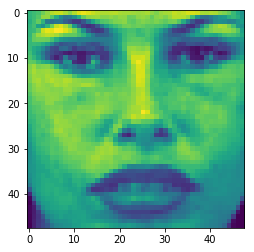

Act: Fear Pred: Neutral


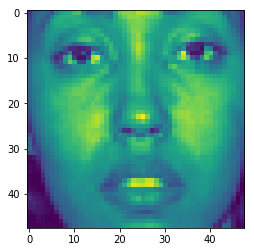

Act: Surprise Pred: Neutral


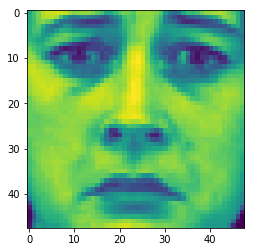

Act: Fear Pred: Sad


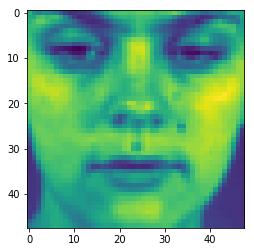

Act: Sad Pred: Neutral


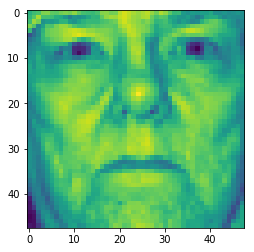

Act: Angry Pred: Neutral


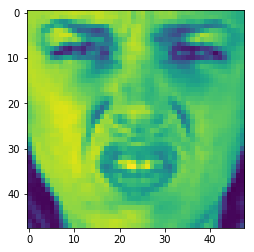

Act: Angry Pred: Disgust


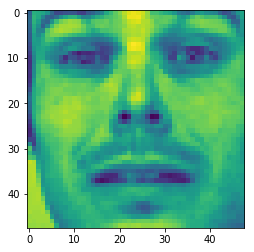

Act: Sad Pred: Fear


In [118]:
#Some of the wrong predictions
for i in range(10,20):
    pred,act = result[i]
    if pred != act:
        plt.imshow(np.reshape([int(x) for x in test_df["pixels"][i]],(48,48)))
        plt.show()
        print("Act: {} Pred: {}".format(emotion_string[pred],emotion_string[act]))

In [103]:
plot_confusion_matrix(y_test,predict_labels,list(range(7)))

NameError: name 'confusion_matrix' is not defined